In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 26,
                    'figure.max_open_warning': 200})
import numpy as np
import pandas as pd
import urllib.request

from date_utils import readable_date, get_date_format

In [2]:
# Dates to plot in the graph -- Must be updated
dates = [get_date_format(d, 3, 2020) for d in range(16, 32)] # March dates (before the 16th many states did not report negative test counts)
dates.extend([get_date_format(d, 4, 2020) for d in range(1, 31)]) # April dates
dates.extend([get_date_format(d, 5, 2020) for d in range(1, 32)]) # May dates
dates.extend([get_date_format(d, 6, 2020) for d in range(1, 18)]) # June dates
readable_dates = list(map(readable_date, dates))
n_dates = len(dates)
print(readable_dates)

['3/16', '3/17', '3/18', '3/19', '3/20', '3/21', '3/22', '3/23', '3/24', '3/25', '3/26', '3/27', '3/28', '3/29', '3/30', '3/31', '4/1', '4/2', '4/3', '4/4', '4/5', '4/6', '4/7', '4/8', '4/9', '4/10', '4/11', '4/12', '4/13', '4/14', '4/15', '4/16', '4/17', '4/18', '4/19', '4/20', '4/21', '4/22', '4/23', '4/24', '4/25', '4/26', '4/27', '4/28', '4/29', '4/30', '5/1', '5/2', '5/3', '5/4', '5/5', '5/6', '5/7', '5/8', '5/9', '5/10', '5/11', '5/12', '5/13', '5/14', '5/15', '5/16', '5/17', '5/18', '5/19', '5/20', '5/21', '5/22', '5/23', '5/24', '5/25', '5/26', '5/27', '5/28', '5/29', '5/30', '5/31', '6/1', '6/2', '6/3', '6/4', '6/5', '6/6', '6/7', '6/8', '6/9', '6/10', '6/11', '6/12', '6/13', '6/14', '6/15', '6/16', '6/17']


In [3]:
# Load Data.
# Thanks to the Covid Tracking Project for collecting excellent data.
url = 'http://covidtracking.com/api/states/daily.csv'
urllib.request.urlretrieve(url, 'Data/states-daily.csv')
df = pd.read_csv("Data/states-daily.csv", sep=',', header=0)
df_vals = df.values

abbrevs_df = pd.read_csv("Data/state_abbreviations.csv", sep=',', header=0)
state_abbrevs = {
    state : abbrev for [state, abbrev] in abbrevs_df.values
}
state_full_names = {
    abbrev: state for [state, abbrev] in abbrevs_df.values
}
# Population data from:
# Table 1. Annual Estimates of the Resident Population for the United States, Regions, States, and Puerto Rico: April 1, 2010 to July 1, 2019 (NST-EST2019-01)
census_df = pd.read_csv("Data/state_populations.csv", sep=',', header=0)
state_pops = {
    state_abbrevs[state].replace(' ', '_'): int(pop.replace(',', '')) for [state, pop] in census_df.values
}

In [4]:
# Helper functions to read the dataframe.
def get_idx(state, date):
    i = np.where(df_vals[:, df.columns.tolist().index('state')] == state)[0]
    j = np.where(df_vals[:, df.columns.tolist().index('date')] == date)[0]
    return set(i).intersection(set(j)).pop()
    
def get_val(state, date, col_name):
    idx = get_idx(state, date)
    return df[[col_name]].values[idx]

def get_positive(state, date):
    return get_val(state, date, 'positive')

def get_negative(state, date):
    return get_val(state, date, 'negative')

def get_total(state, date):
    return get_val(state, date, 'total')

In [5]:
# The main part of the model to estimate total number of infections.
def calc_sum_z(N, num_pos, num_neg, c):
    try:
        return (N*num_pos) / (c*num_neg + num_pos)
    except:
        return (N*num_pos) / (c(N, num_pos, num_neg)*num_neg + num_pos)

def get_latent_total(state, date, c):
    return calc_sum_z(state_pops[state], get_positive(state, date), get_negative(state, date), c)

In [6]:
# Shared plotting helpers.
markers = ['.', '+', '*', '^']

def finalize_plot(dates, y_label, fname, separate_legend=True, extension="pdf"):
    plt.xlim([0, len(dates)-1])
    locs, labels = plt.xticks()
    locs = locs[:-1]
    plt.xticks(locs, [readable_dates[int(i)] for i in locs], fontsize=28)
    plt.xlabel("Date", fontsize=40)
    plt.ylabel(y_label, fontsize=40)
    plt.yticks(fontsize=28)
    if not separate_legend:
        lgd = plt.legend(bbox_to_anchor=(1.0, 0.9), fontsize=22)
        plt.savefig(fname, dpi=300, bbox_inches='tight', bbox_artists=[lgd])
    else:
        plt.savefig(fname, dpi=300, bbox_inches='tight')
        lgd = plt.legend(bbox_to_anchor=(1.0, 0.9), fontsize=22)
        def export_legend(legend, filename):
            fig  = legend.figure
            fig.canvas.draw()
            bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
            bbox.x0 *= 0.99
            bbox.y0 *= 0.9
            bbox.y1 *= 1.02
            bbox.x1 *= 1.01
            fig.savefig(filename, dpi=300, bbox_inches=bbox)
        export_legend(lgd, "results/legend.{}".format(extension))
    
def plot_pos_neg_pop(state, dates):
    positives = np.array([get_positive(state, date) for date in dates])
    negatives = np.array([get_negative(state, date) for date in dates])
    pop = np.array([state_pops[state] for date in dates])
    plt.semilogy(pop, label='State Population', color='black', marker='+')
    plt.semilogy(positives, label='Cumulative Positive Tests', color='red', marker='+')
    plt.semilogy(negatives, label='Cumulative Negative Tests', color='green', marker='+')

In [7]:
# Estimate c(t) based on seroloprevalence studies.
def calc_c(N, n_p, n_n, Z):
    return ((N*n_p) / (Z*n_n) - (n_p / n_n))

def calc_c_for_state_and_date(state, date, Z):
    N = state_pops[state]
    n_p = get_positive(state, date)[0]
    n_n = get_negative(state, date)[0]
    return calc_c(N, n_p, n_n, Z)

easy_date = lambda x: dates[readable_dates.index(x)]

# NY Study
c_ny1 = calc_c_for_state_and_date("NY", easy_date("4/21"), 0.139*state_pops["NY"]) 
c_ny2 = calc_c_for_state_and_date("NY", easy_date("5/2"), 0.123*state_pops["NY"])
print("NY1: {:.1f}, NY2: {:.1f}".format(c_ny1, c_ny2))

# ID study
c_idaho = calc_c_for_state_and_date("ID", easy_date("4/25"), 0.0179*state_pops["ID"])
print("ID: {:.1f}".format(c_idaho))

# Santa Clara - Manually coding the county population since it isn't included in the file of state populations.
pop_sc = 1928000 # Santa Clara county population
pos_sc = 1148
neg_sc = 10912

# SC-B
# Zs from Santa Clara seroprevalence study with original analysis
scb_min = 0.018*pop_sc
scb_max = 0.057*pop_sc
c_scb_min = calc_c(pop_sc, pos_sc, neg_sc, scb_min)
c_scb_max = calc_c(pop_sc, pos_sc, neg_sc, scb_max)
print("SC-B (2.5%): {:.1f}, SC-B (97.5%): {:.1f}".format(c_scb_min, c_scb_max))

# SC-S
# Zs from Santa Clara seroprevalence study with Steinberg's correction
scs_min = 0.00094*pop_sc 
scs_max = 0.0167*pop_sc
scs_mean = 0.0081*pop_sc
c_scs_min = calc_c(pop_sc, pos_sc, neg_sc, scs_min)
c_scs_max = calc_c(pop_sc, pos_sc, neg_sc, scs_max)
print("SC-S (2.5%): {:.1f}, SC-S (97.5%): {:.1f}".format(c_scs_min, c_scs_max))

NY1: 3.9, NY2: 3.5
ID: 5.8
SC-B (2.5%): 5.7, SC-B (97.5%): 1.7
SC-S (2.5%): 111.8, SC-S (97.5%): 6.2


In [8]:
# Estimate c(t) based on symptomatic rates.
prevalence_flu = 0.01
prevalence_cold = 0.1
symptomatic_covid = 0.5

c_cold = symptomatic_covid / (prevalence_cold + prevalence_flu)
c_flu  = symptomatic_covid / (prevalence_flu)

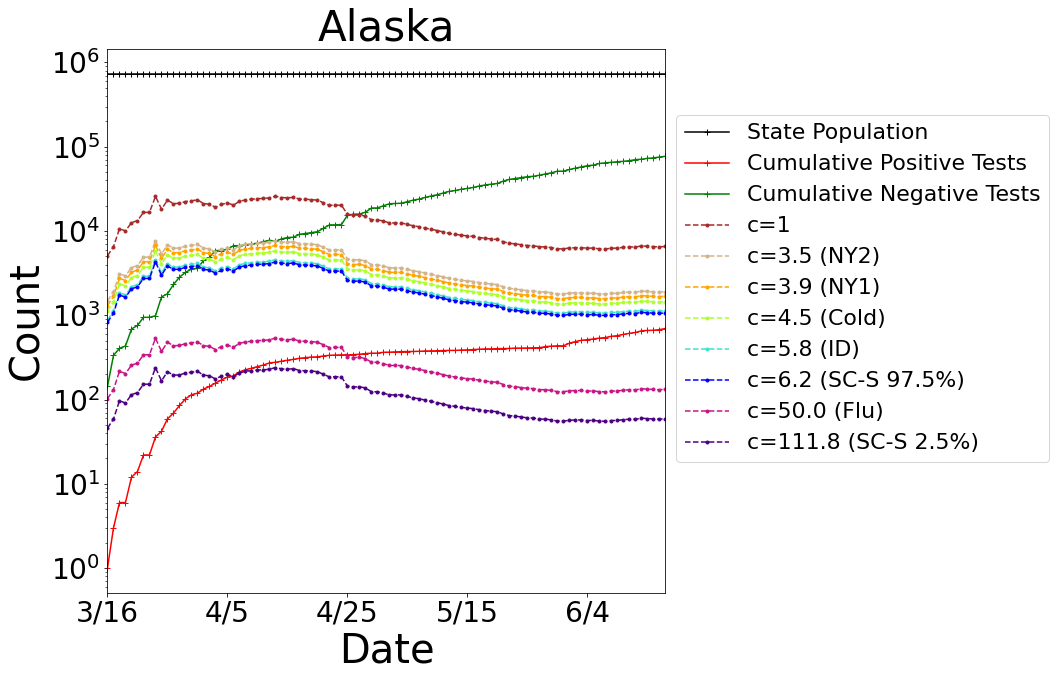

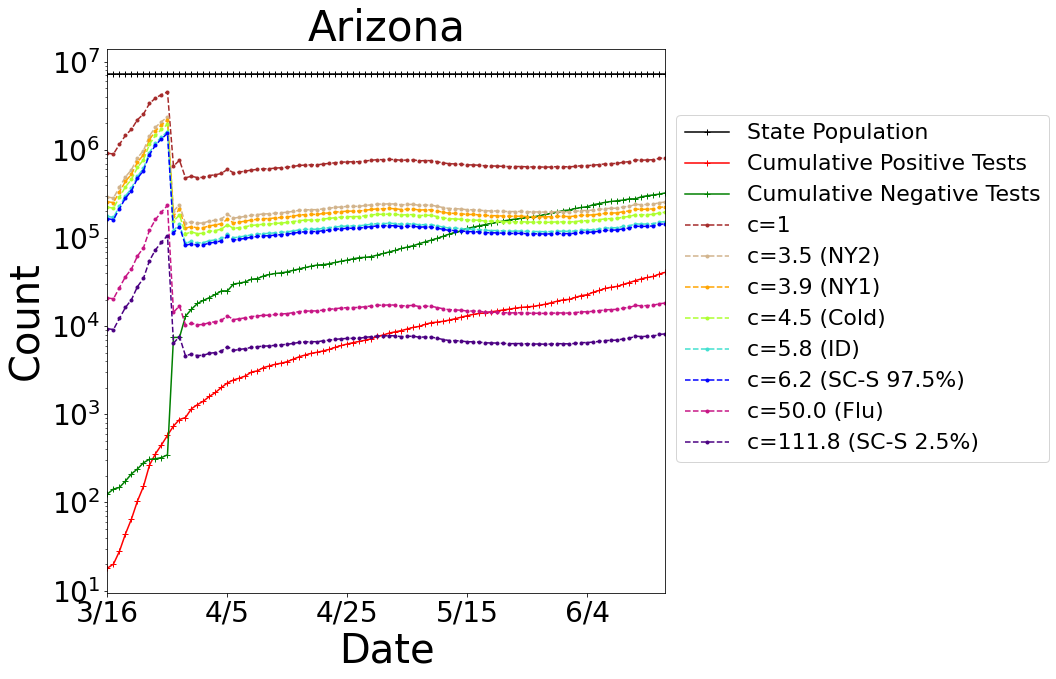

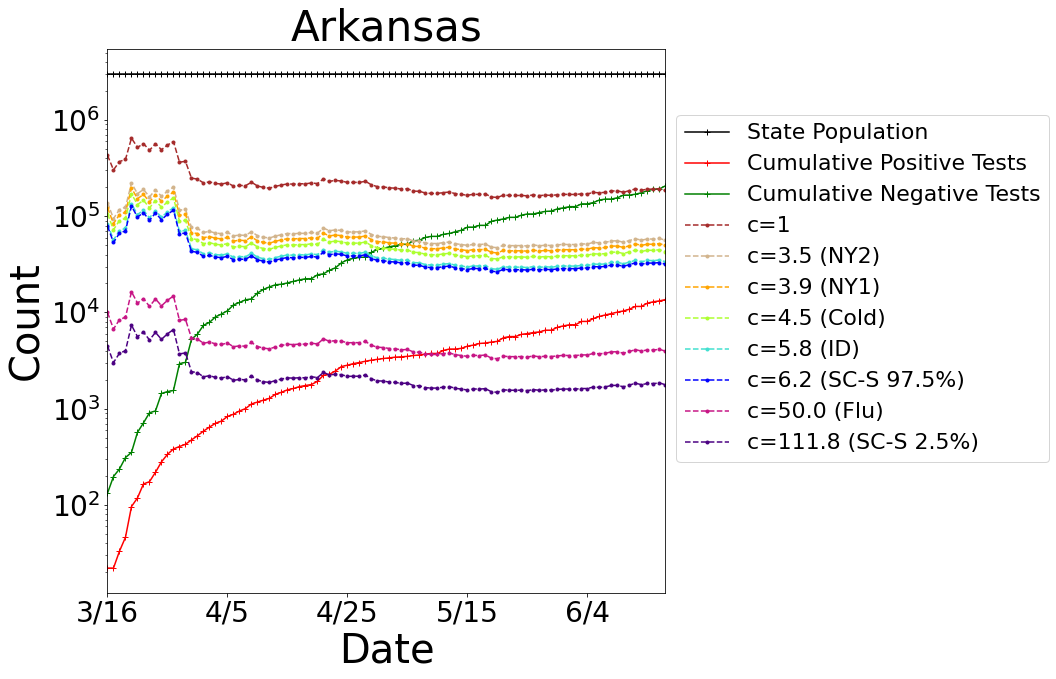

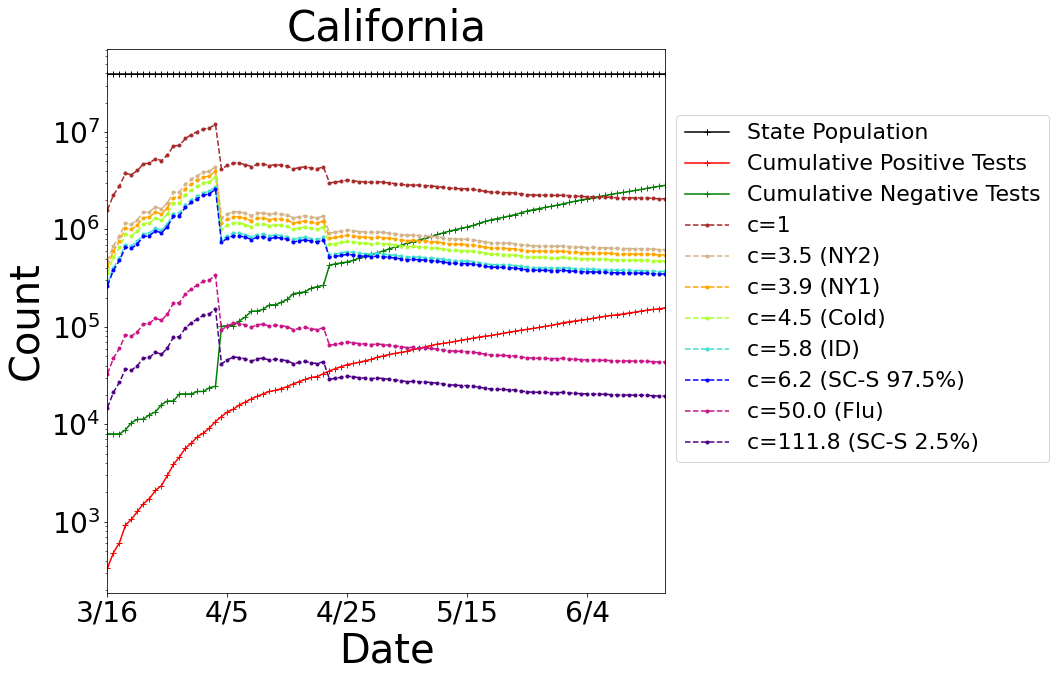

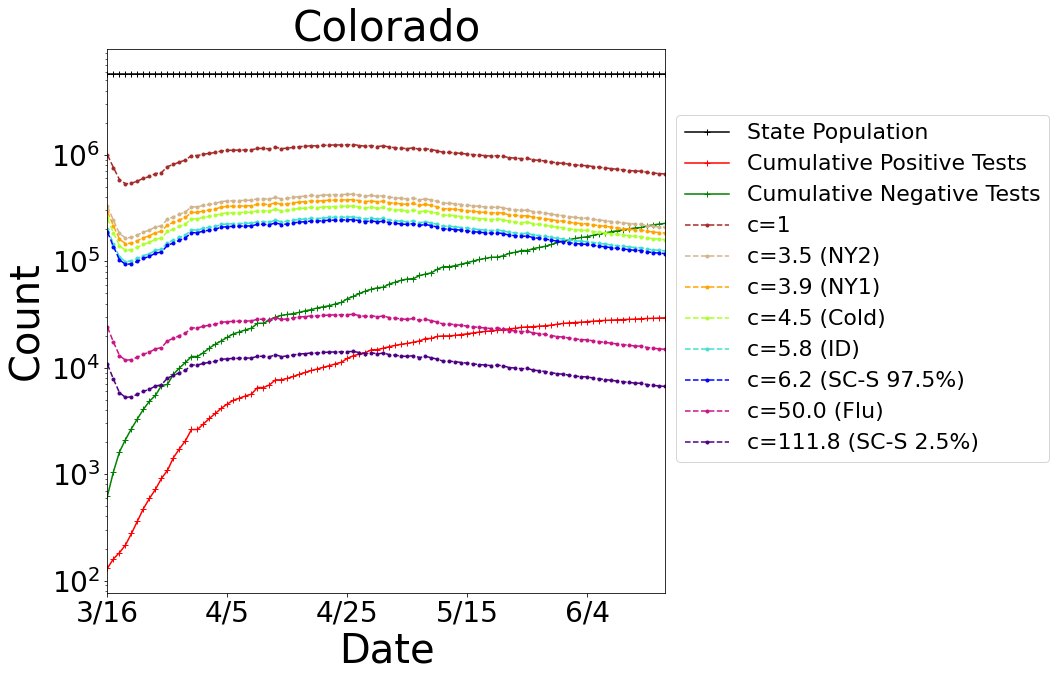

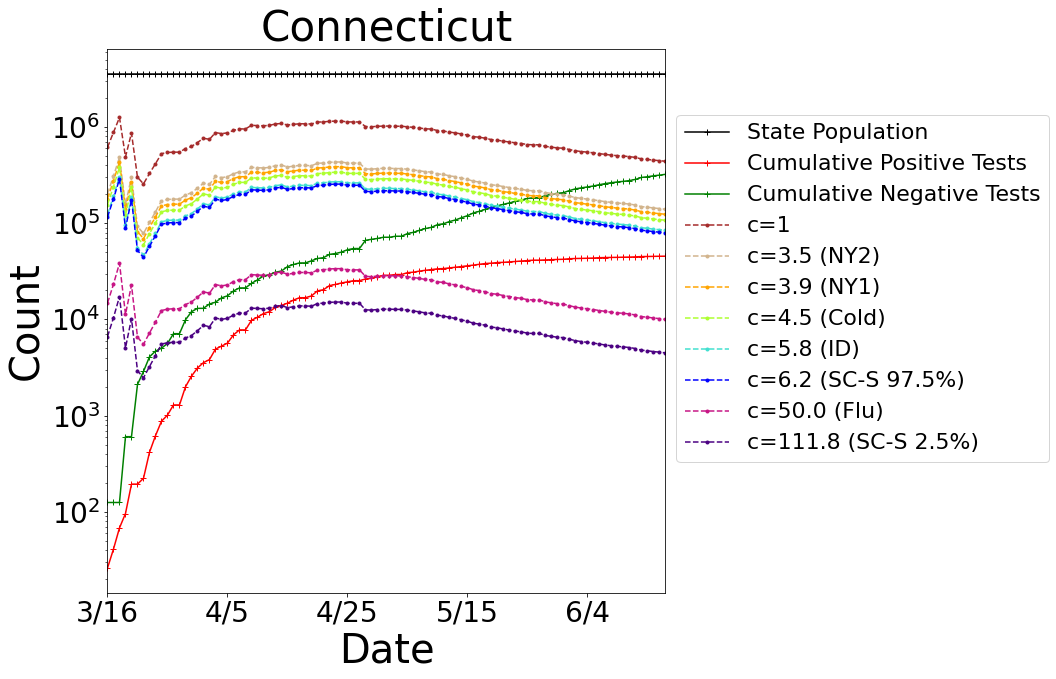

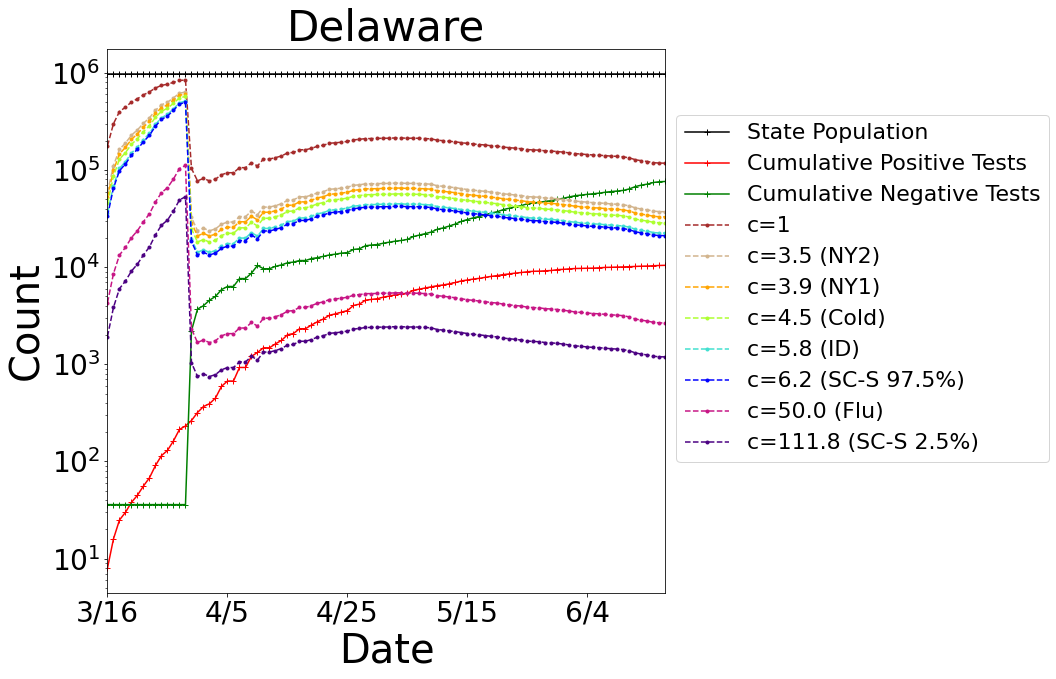

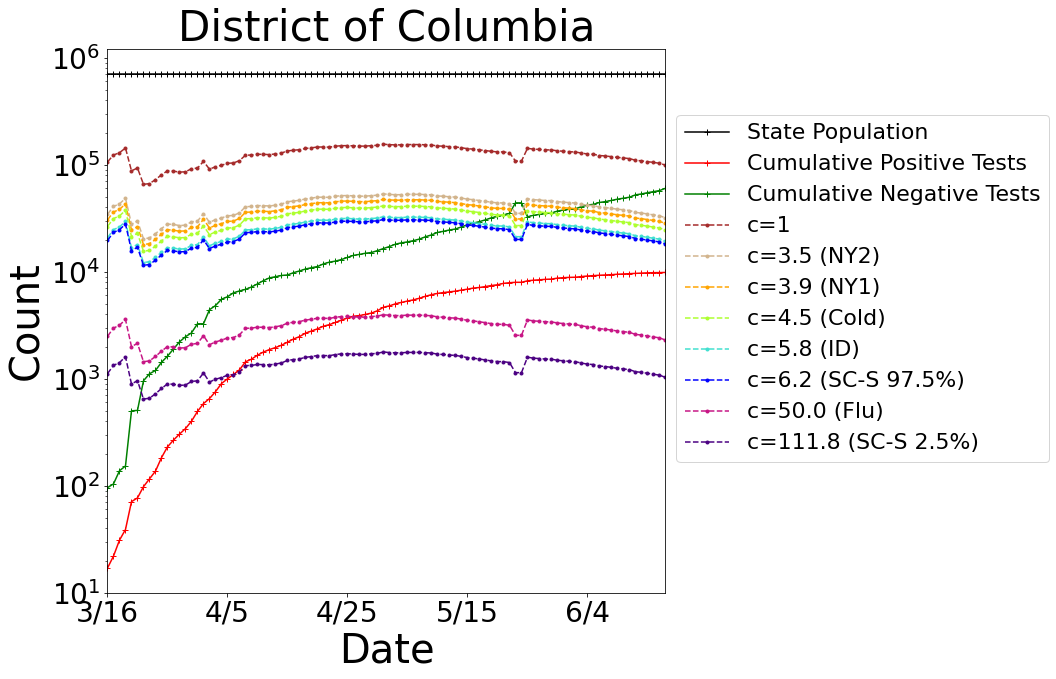

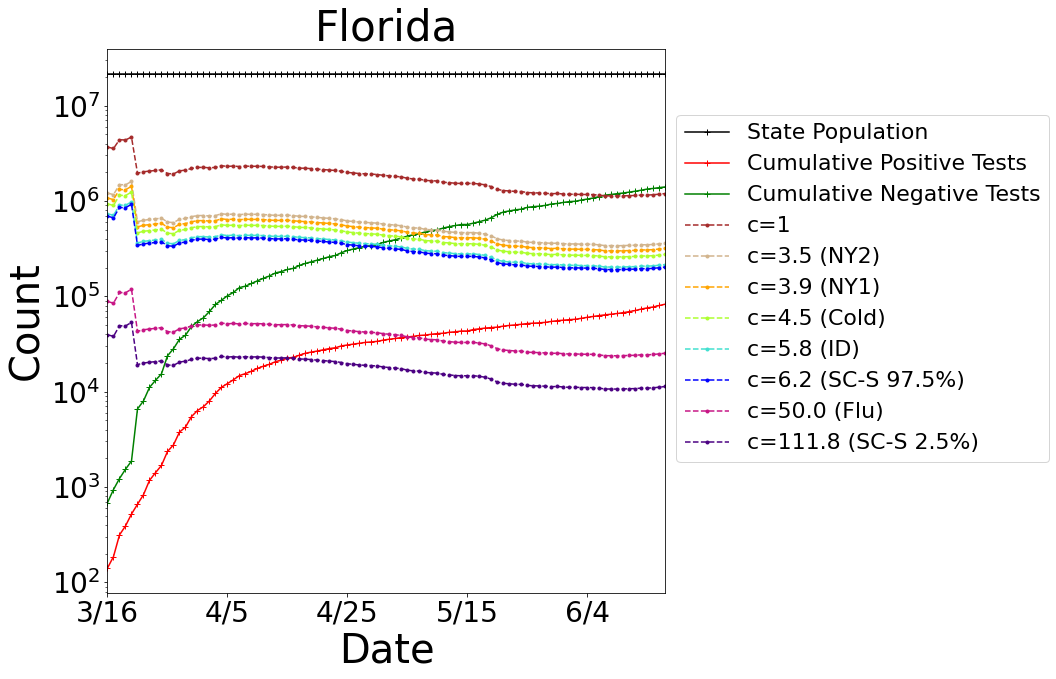

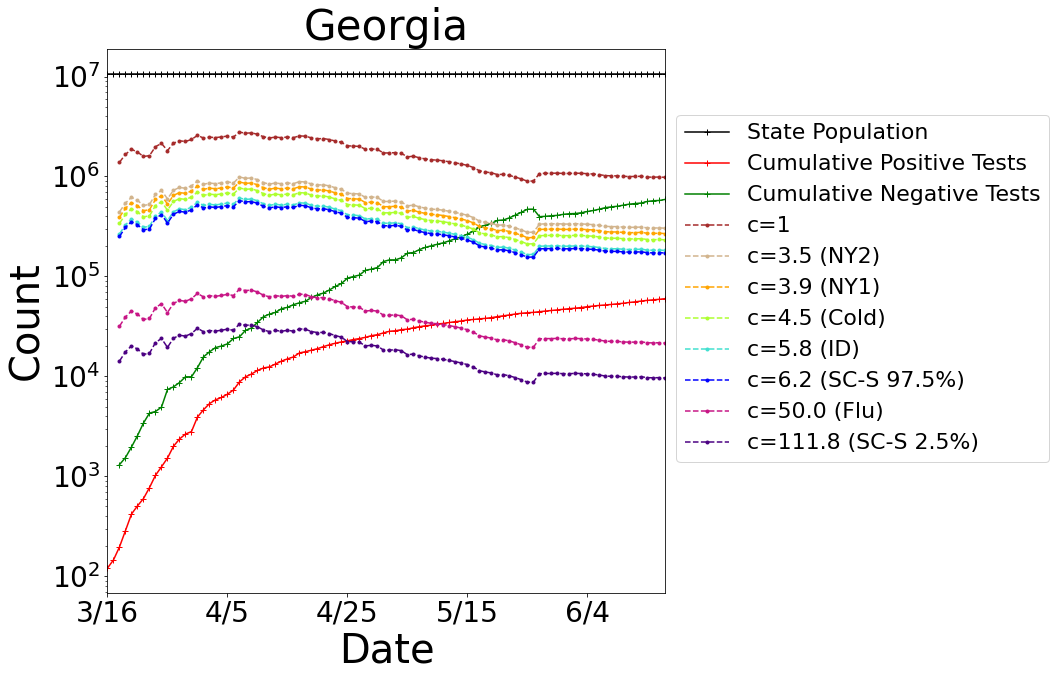

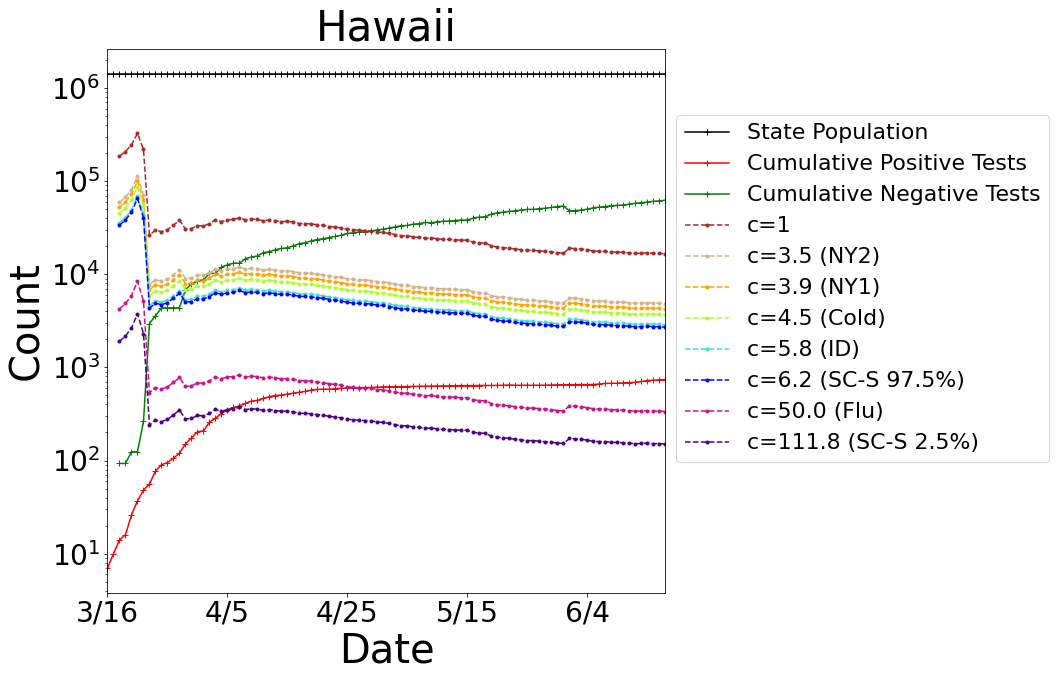

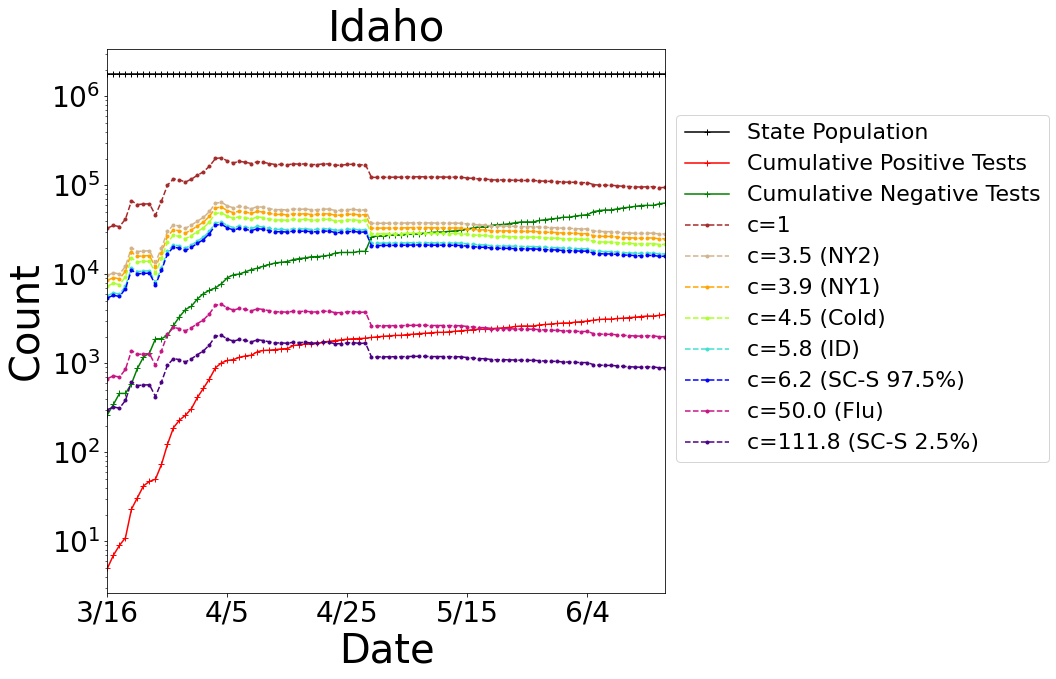

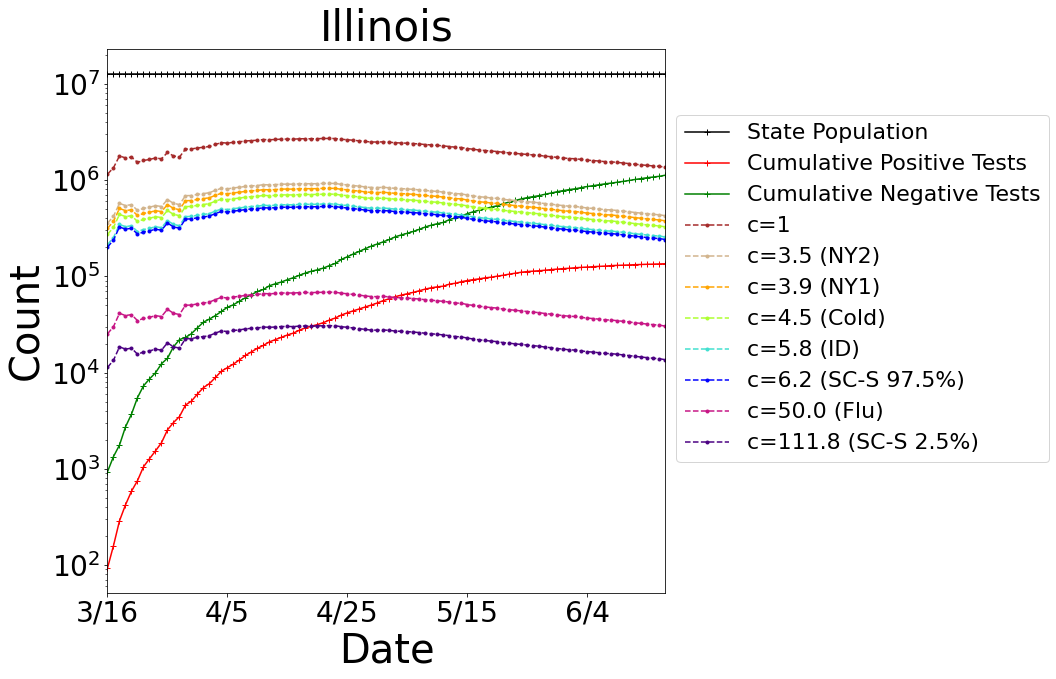

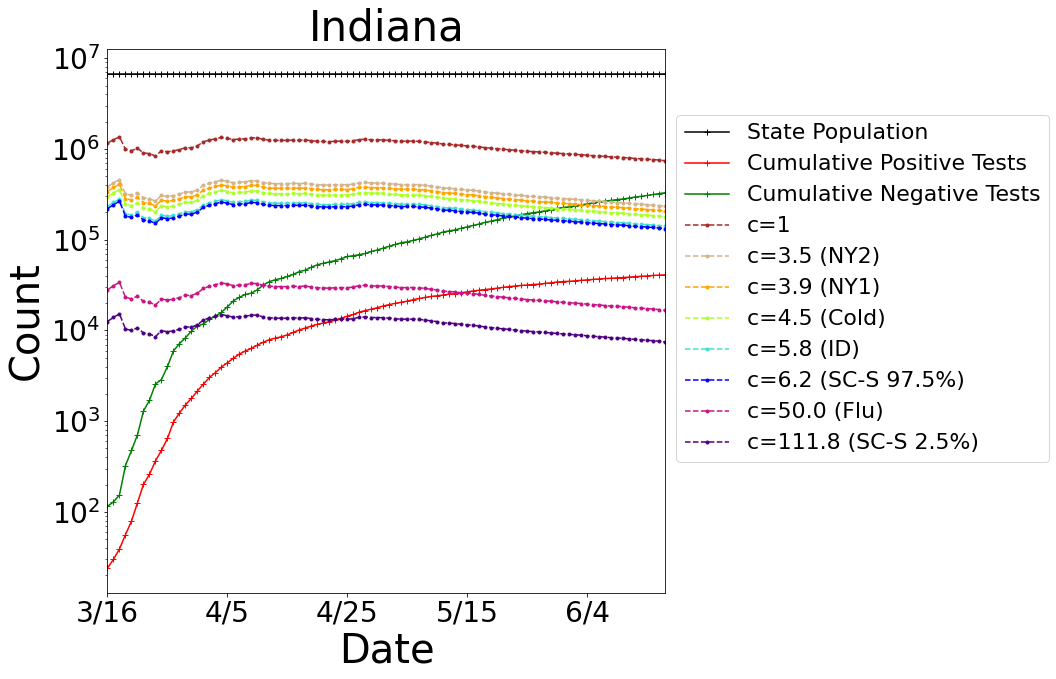

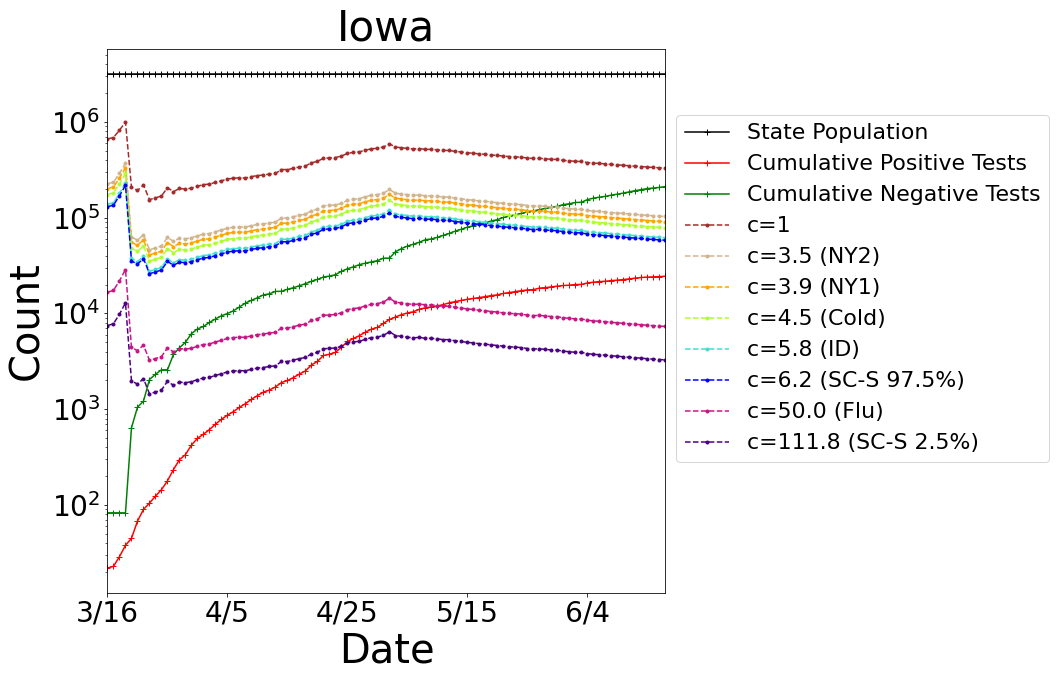

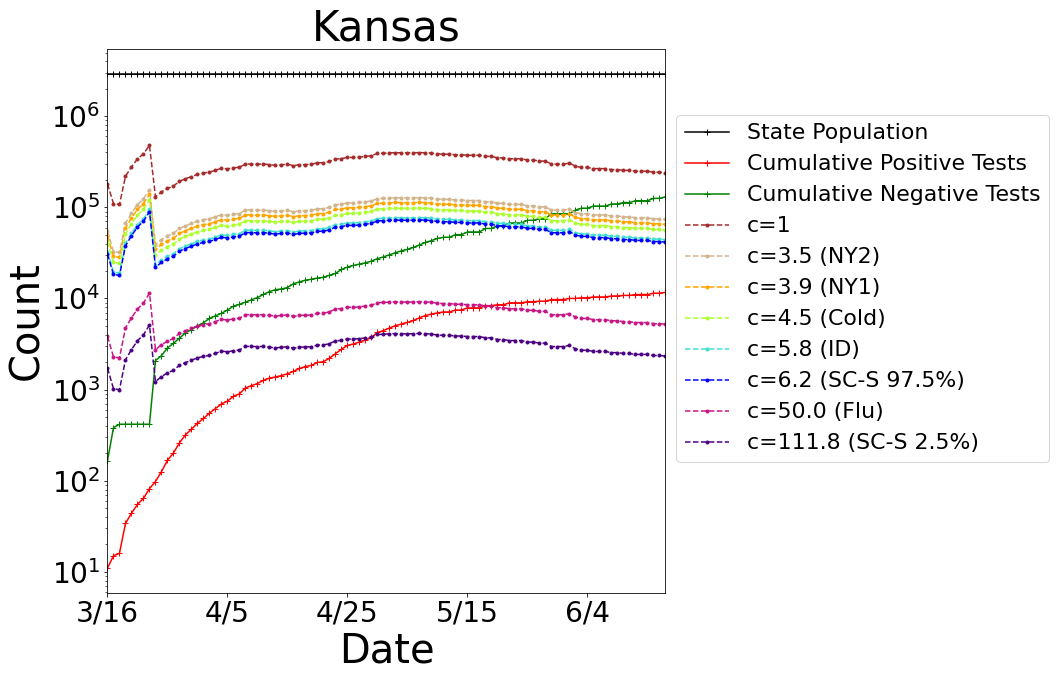

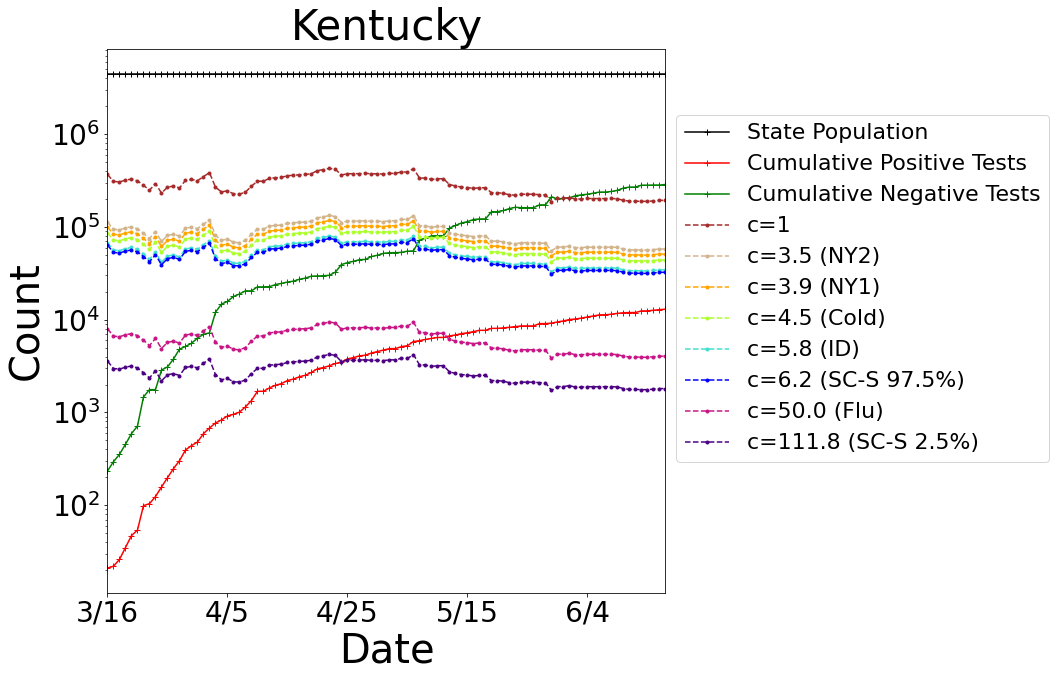

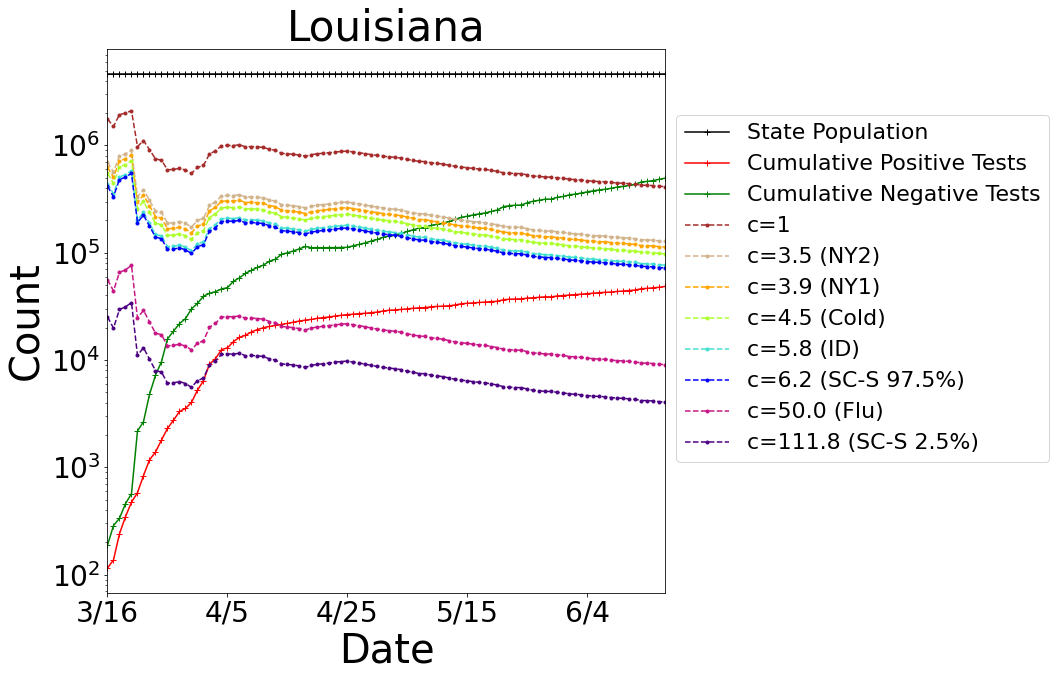

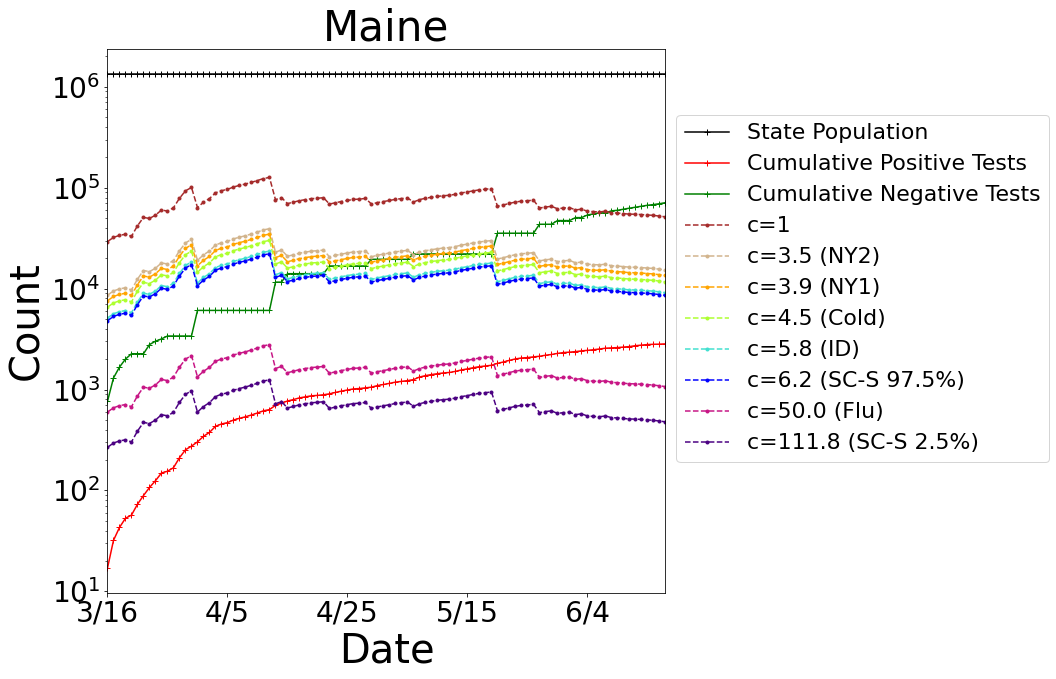

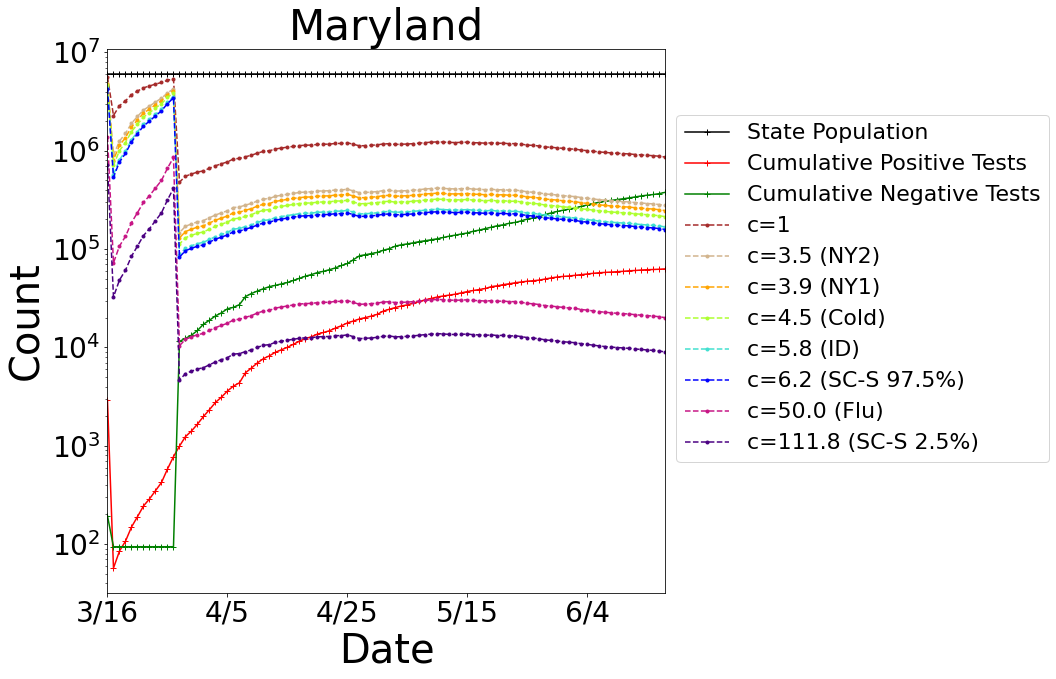

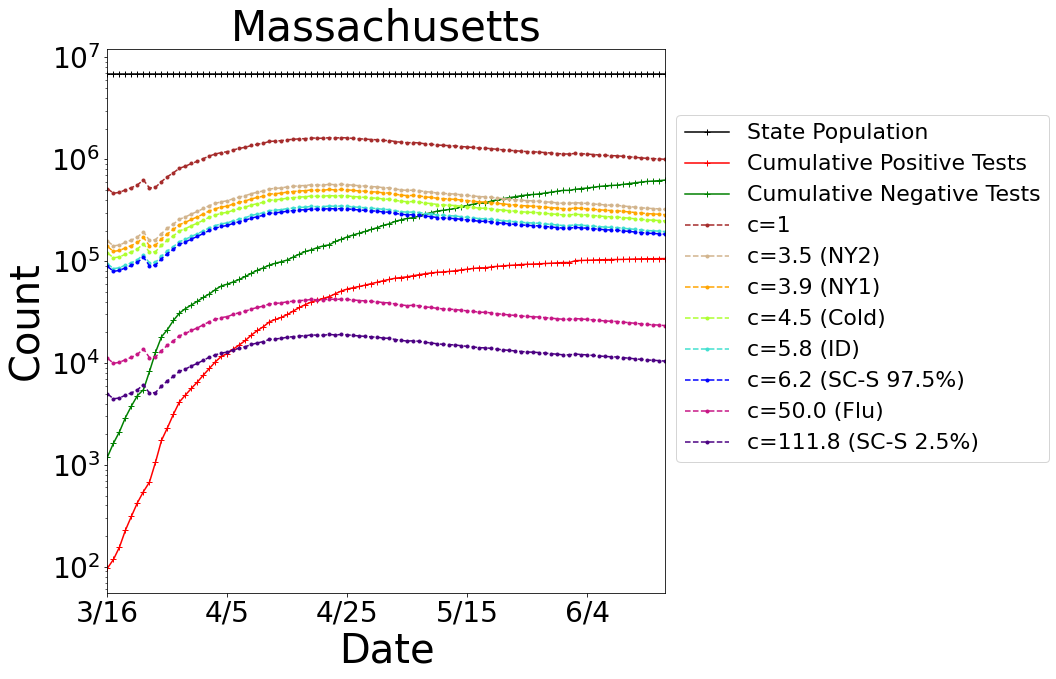

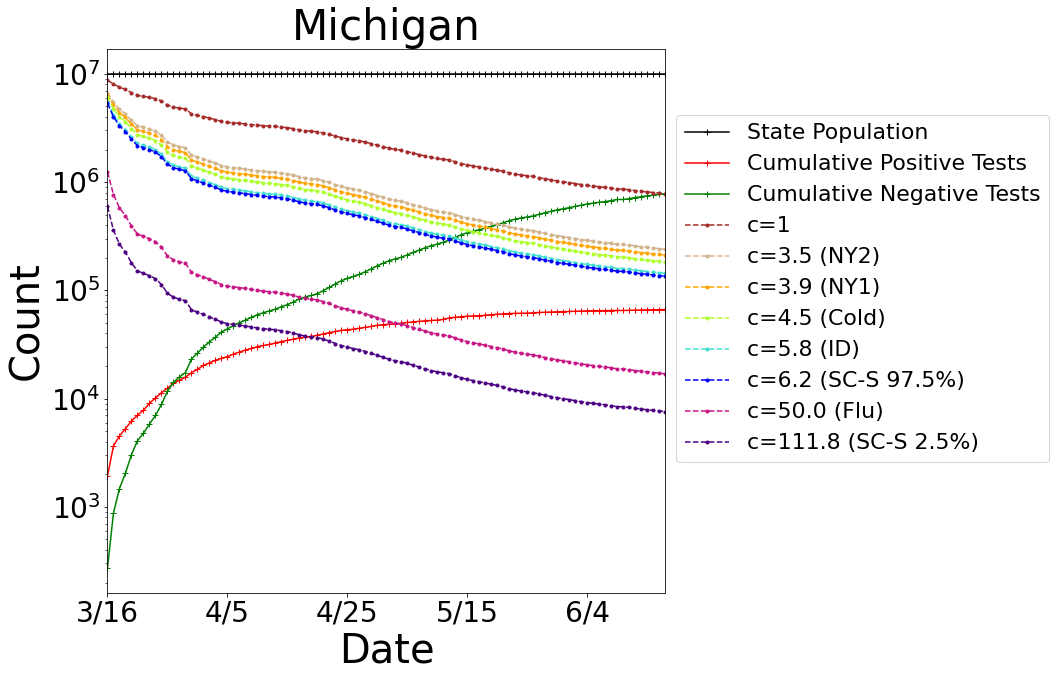

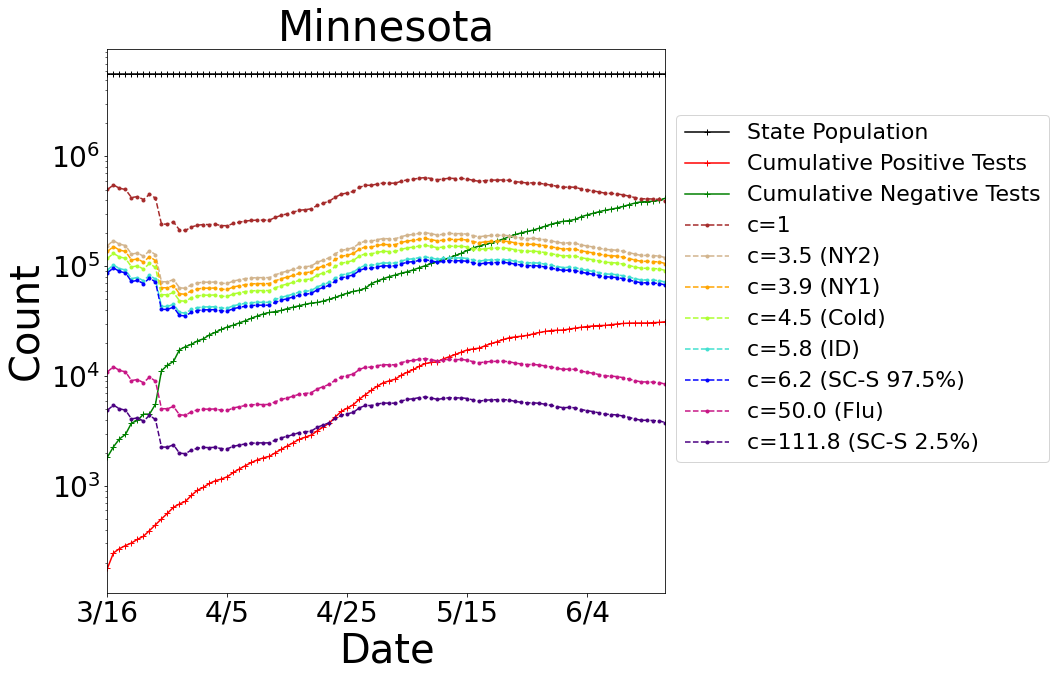

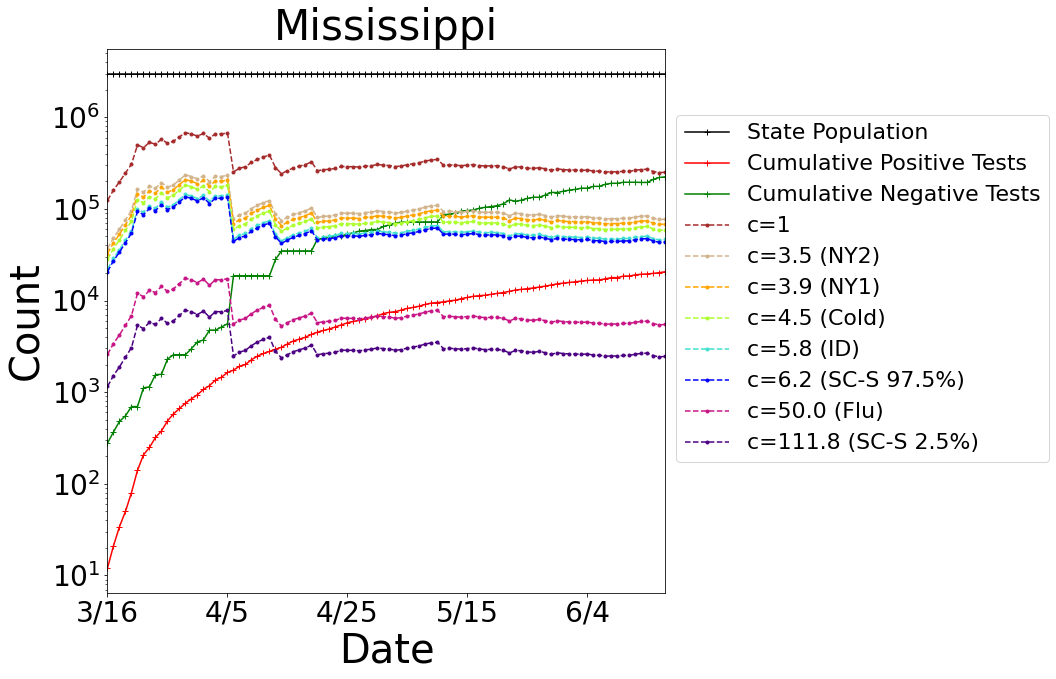

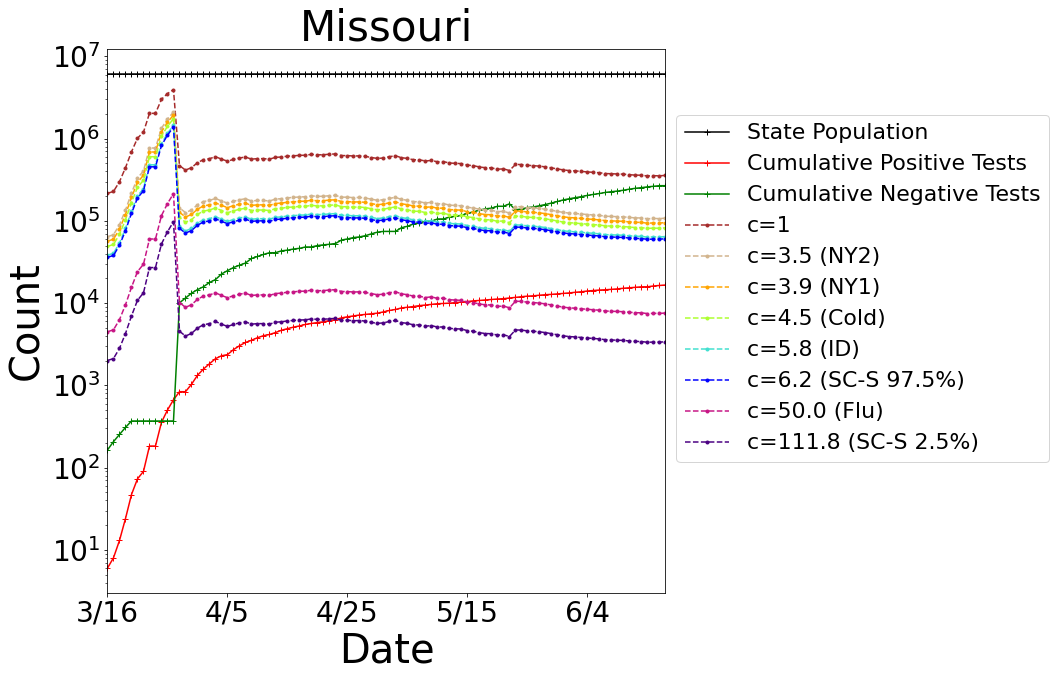

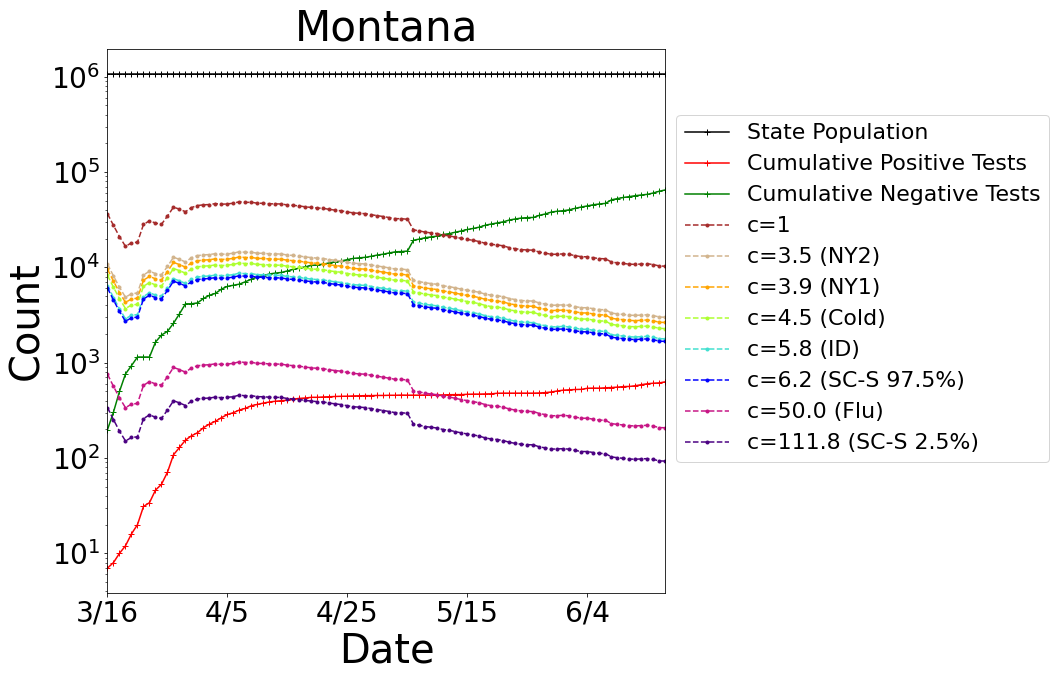

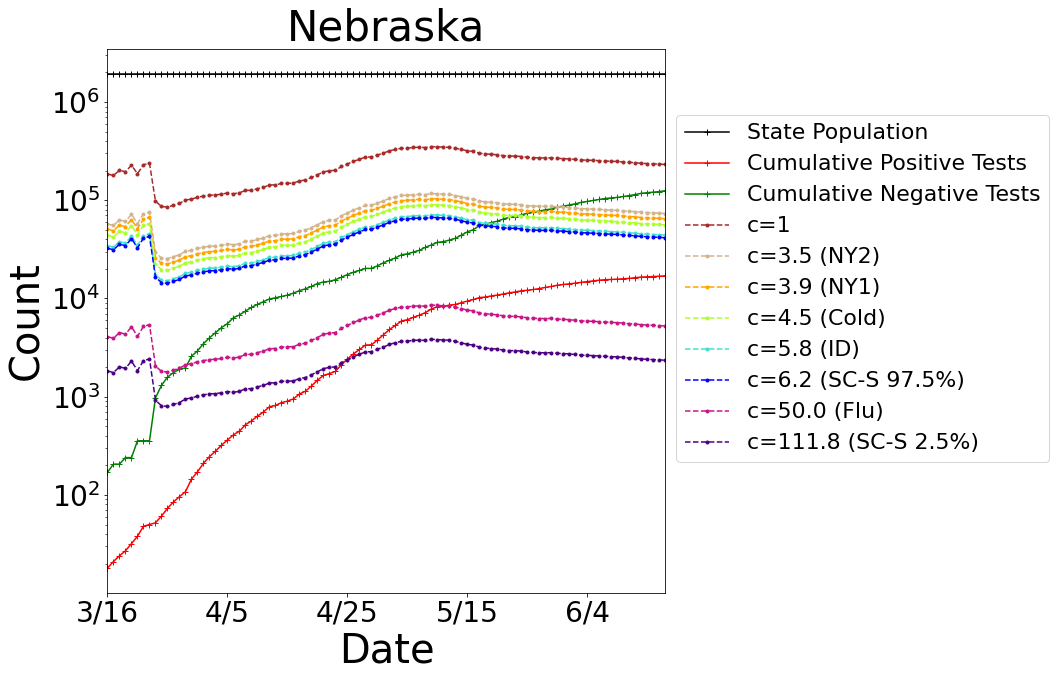

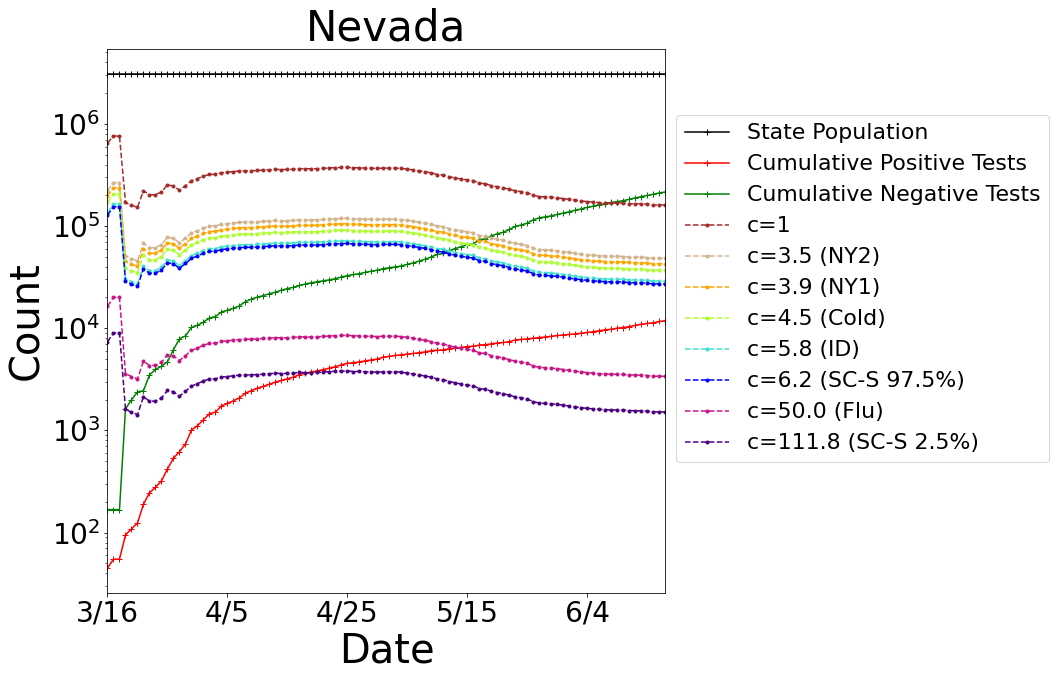

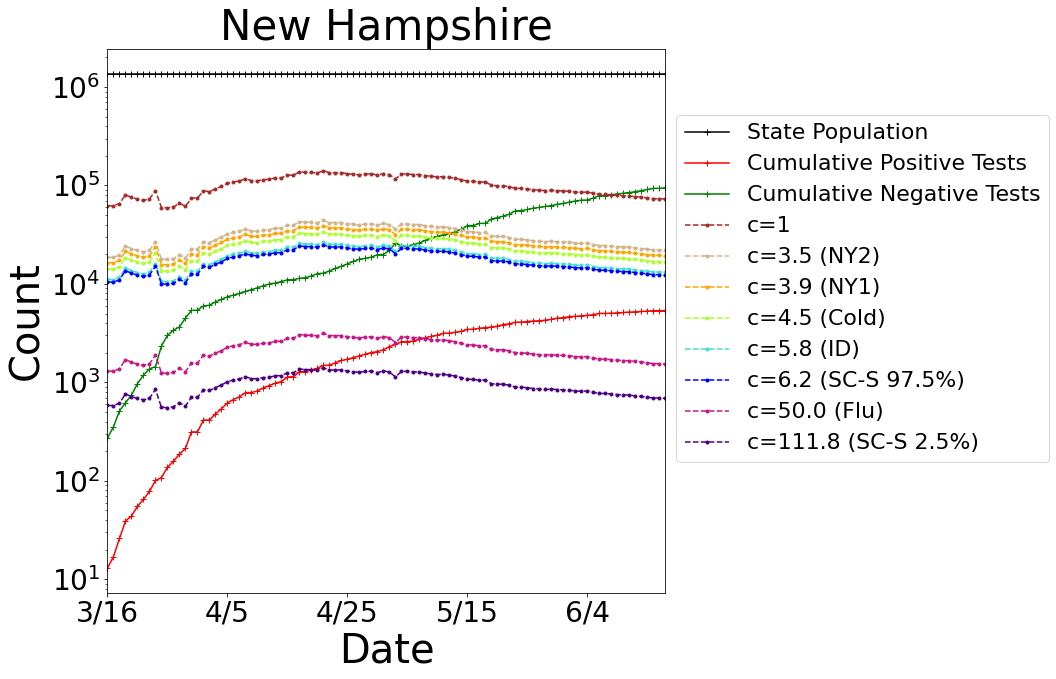

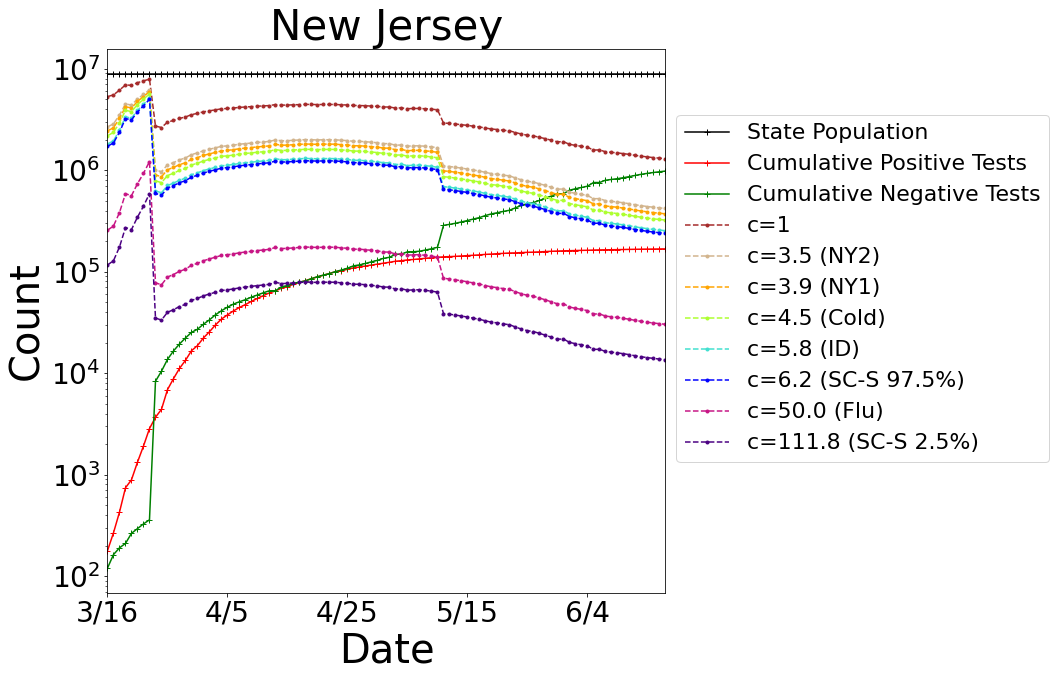

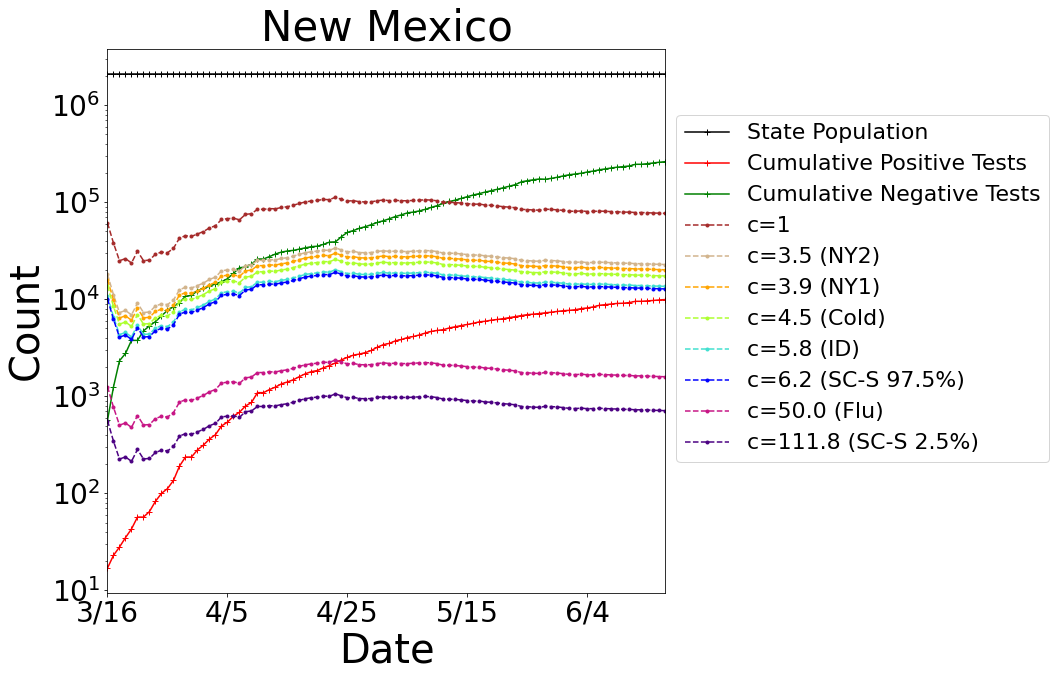

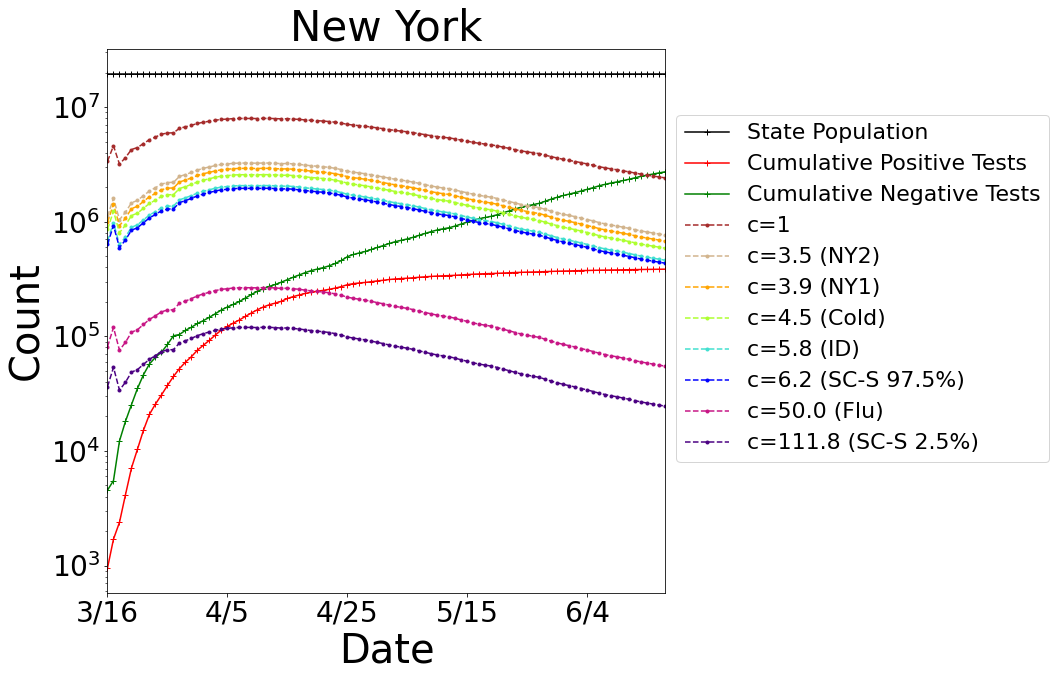

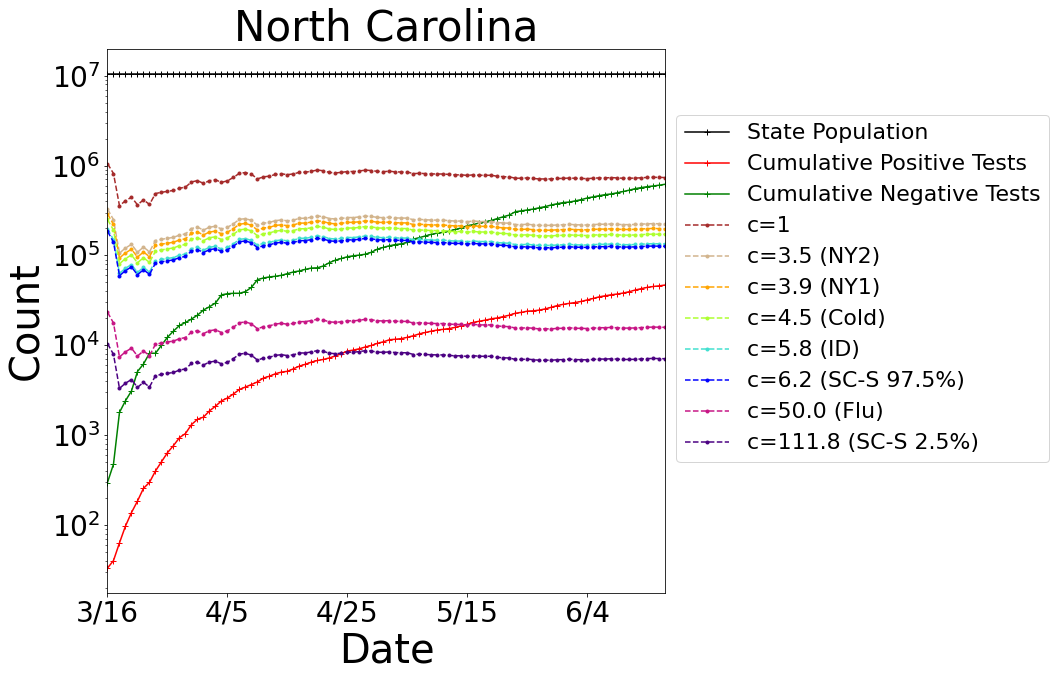

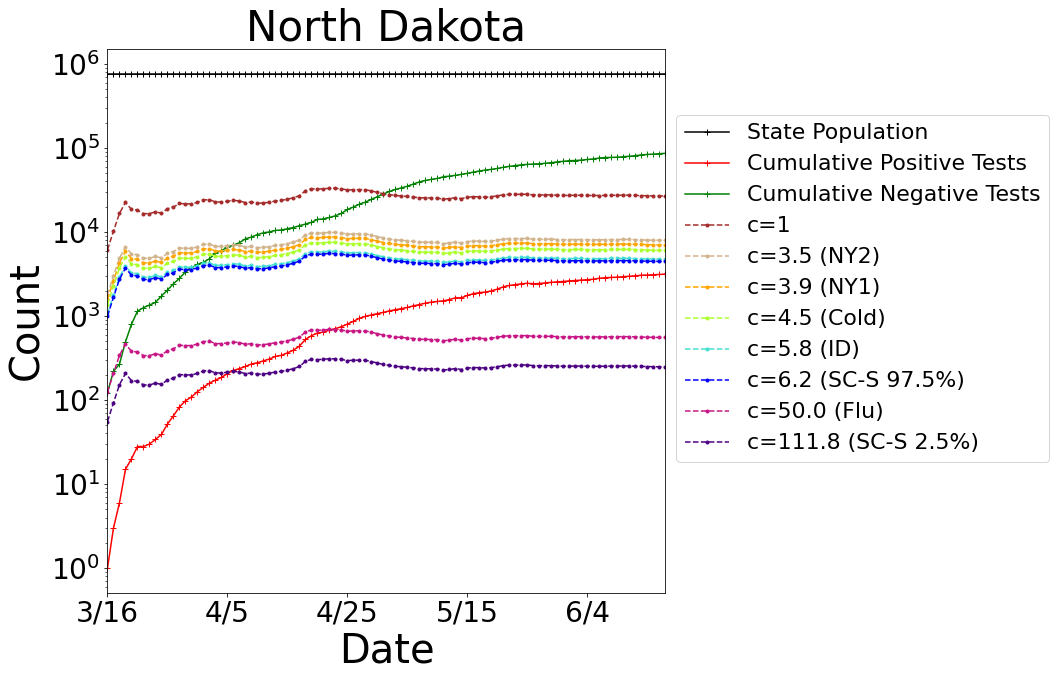

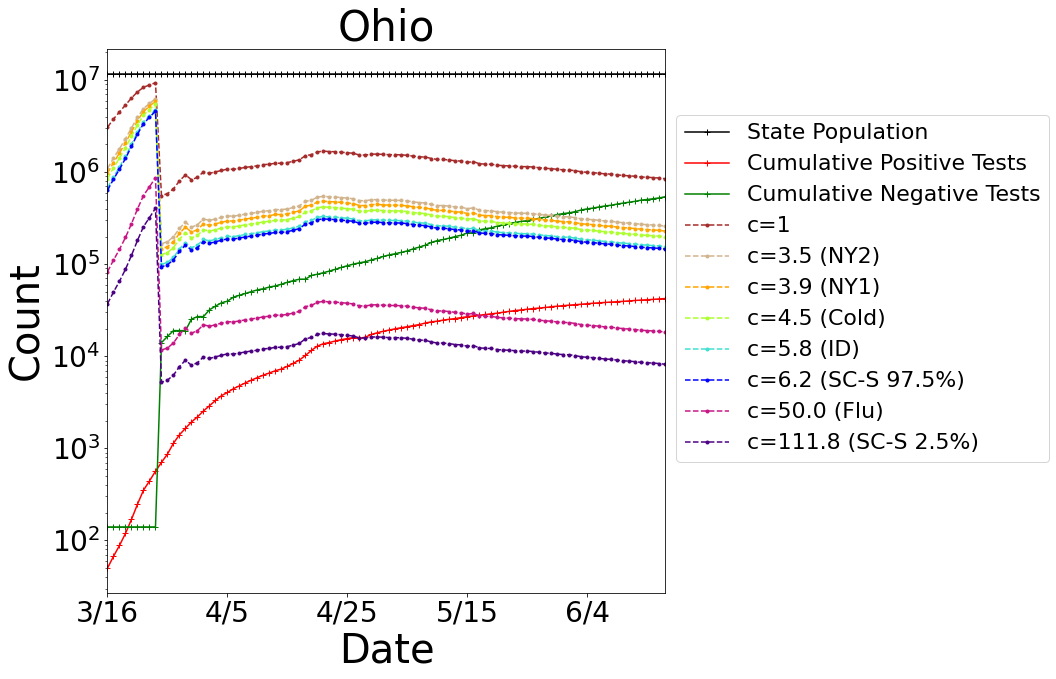

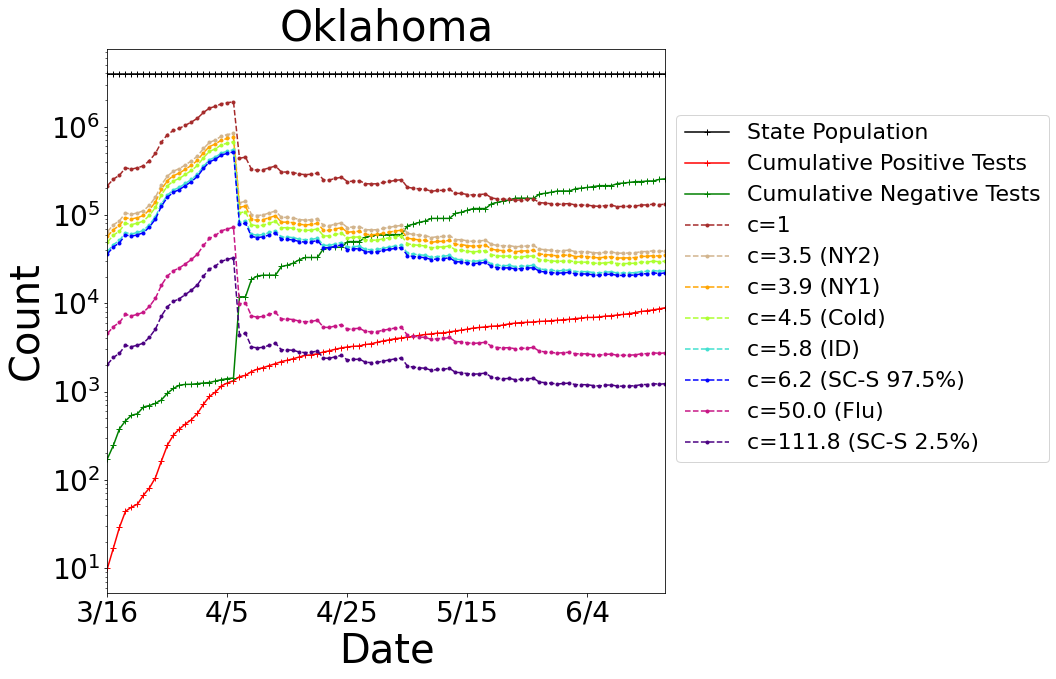

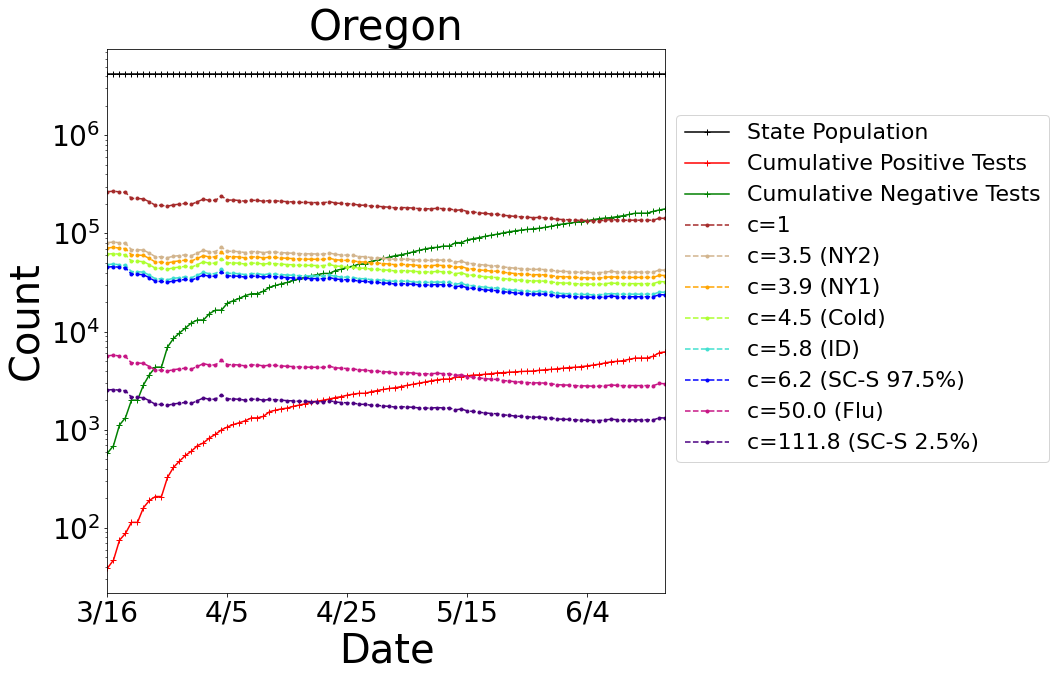

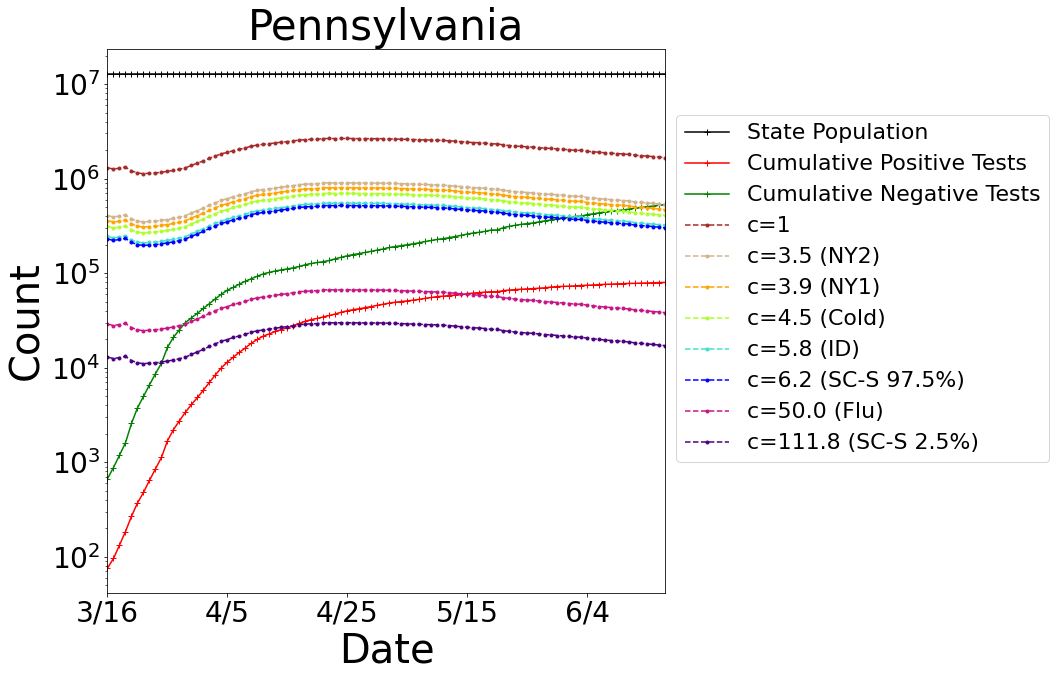

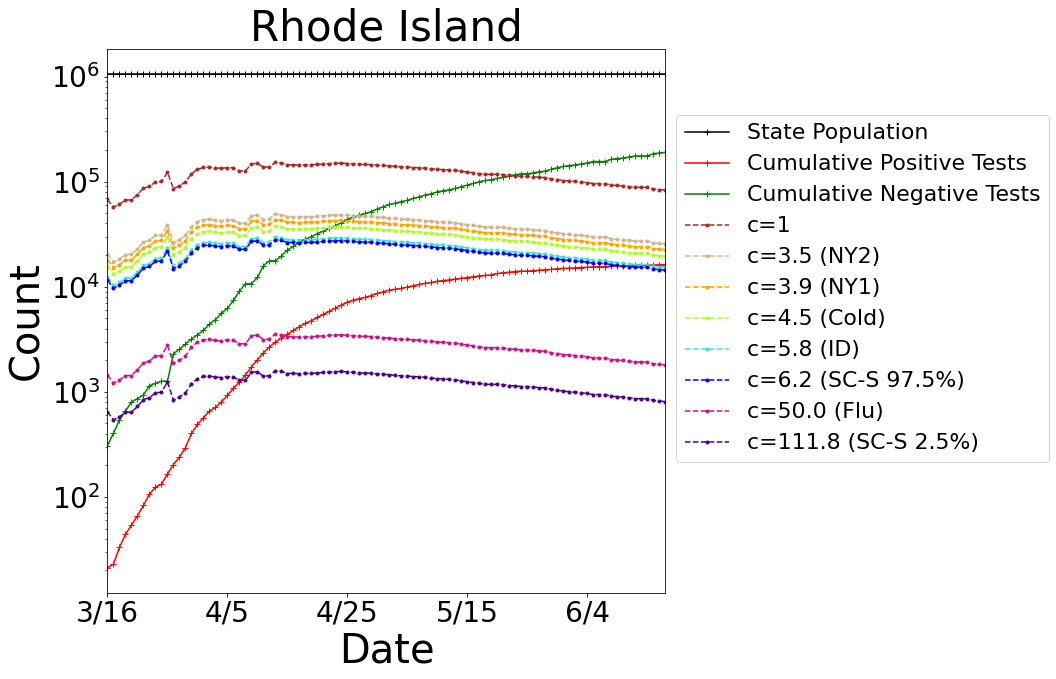

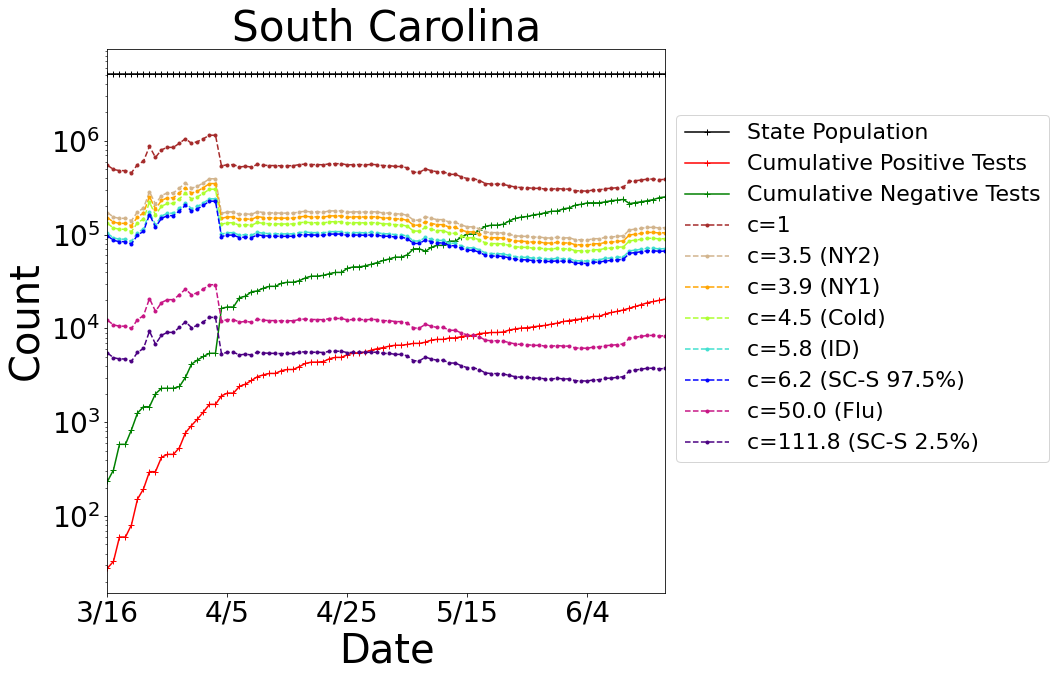

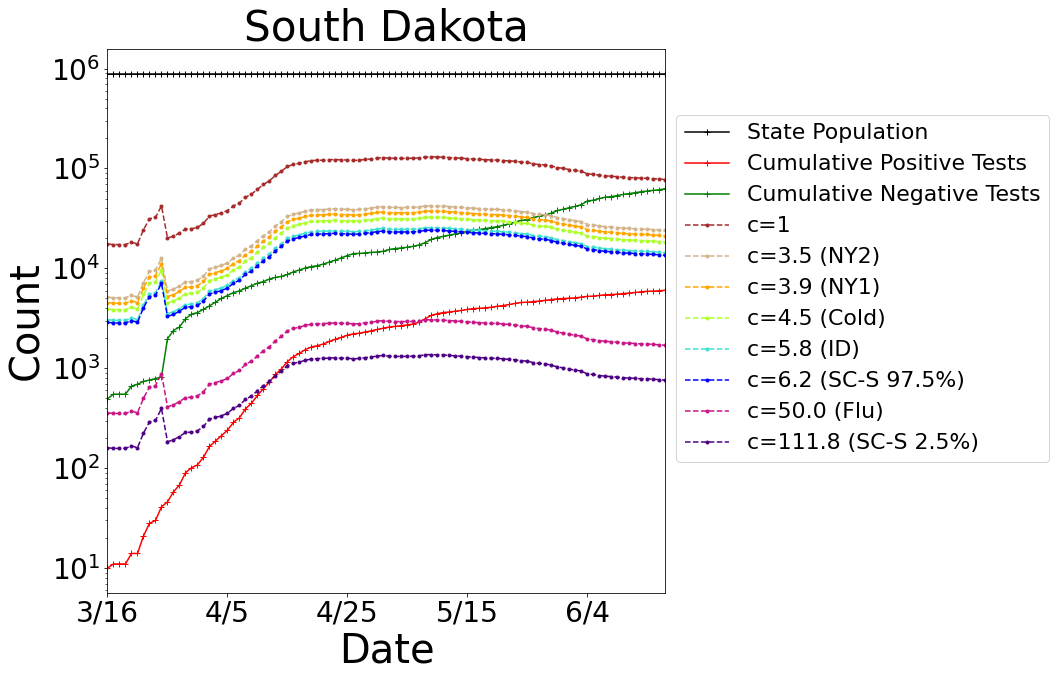

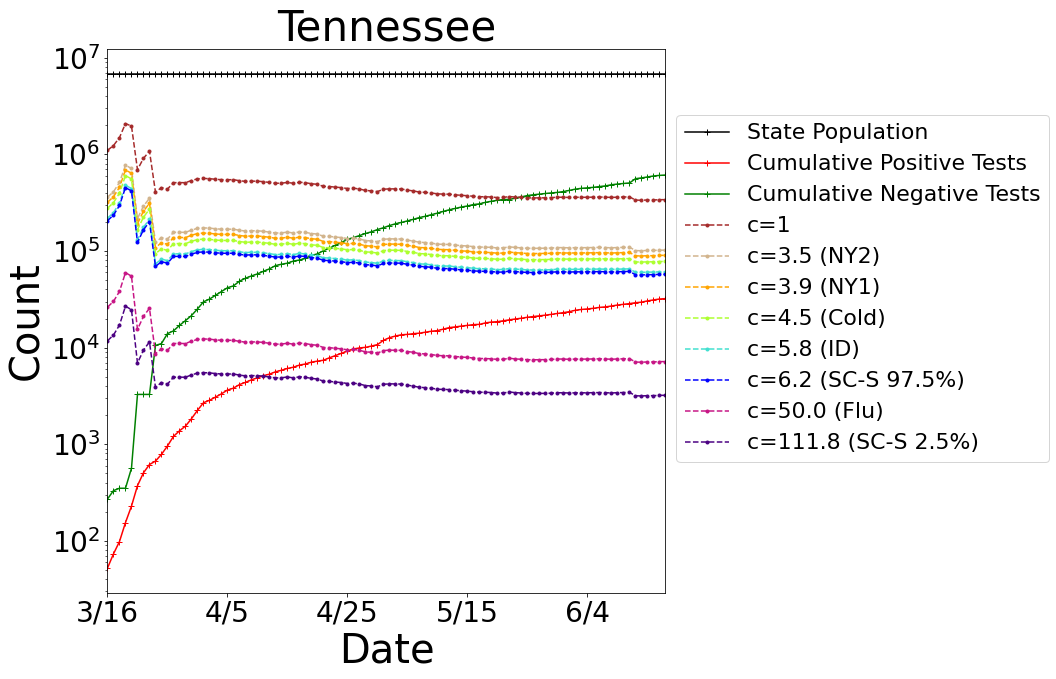

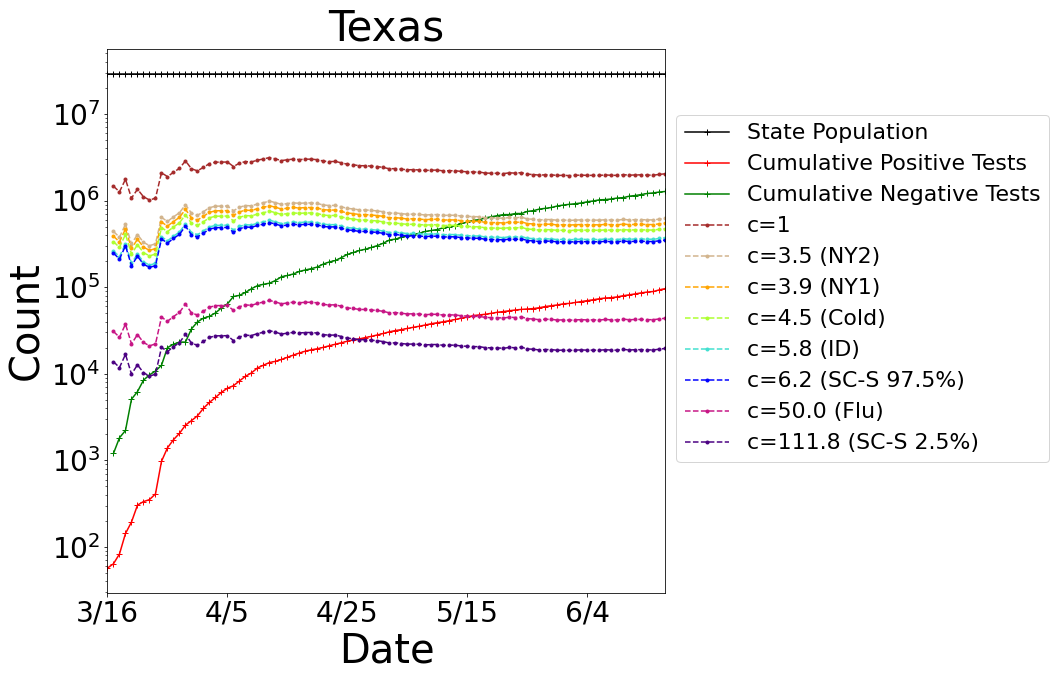

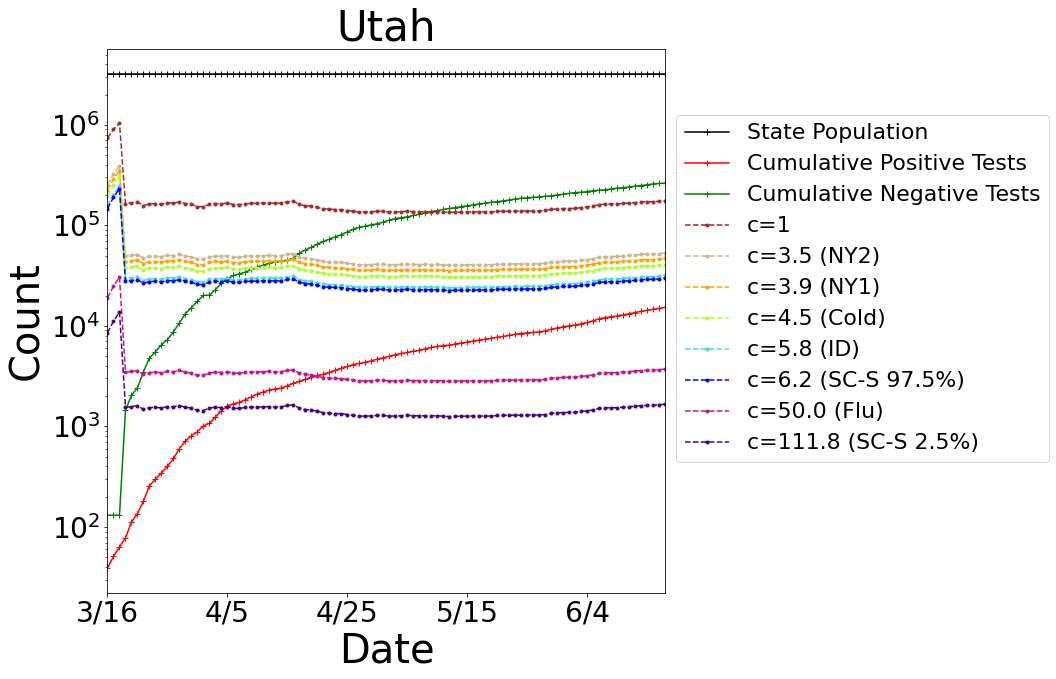

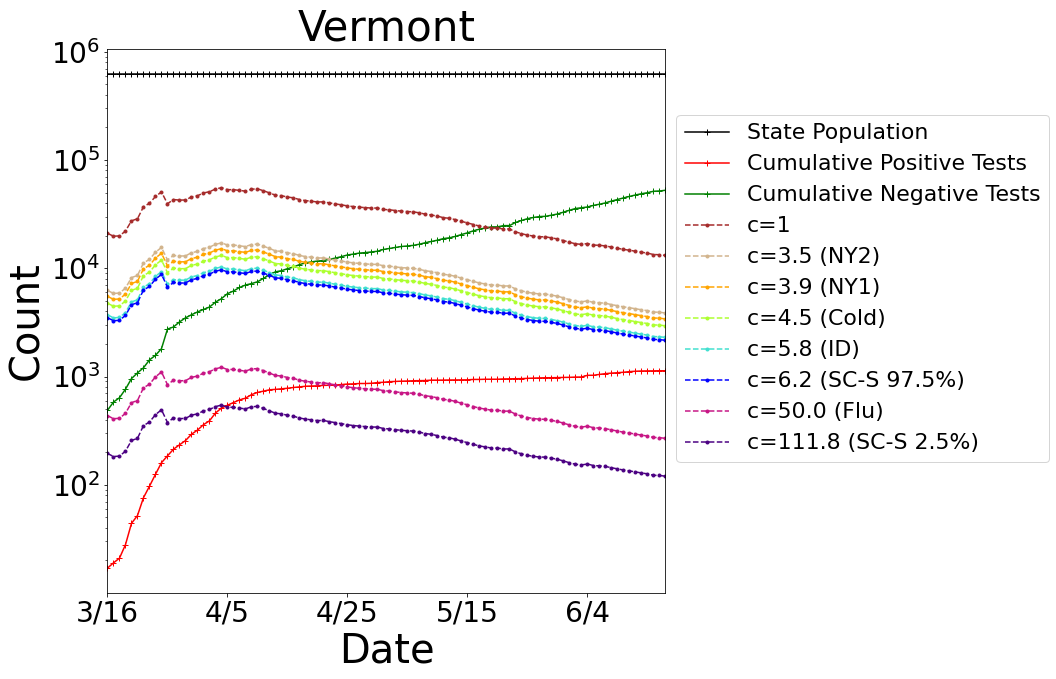

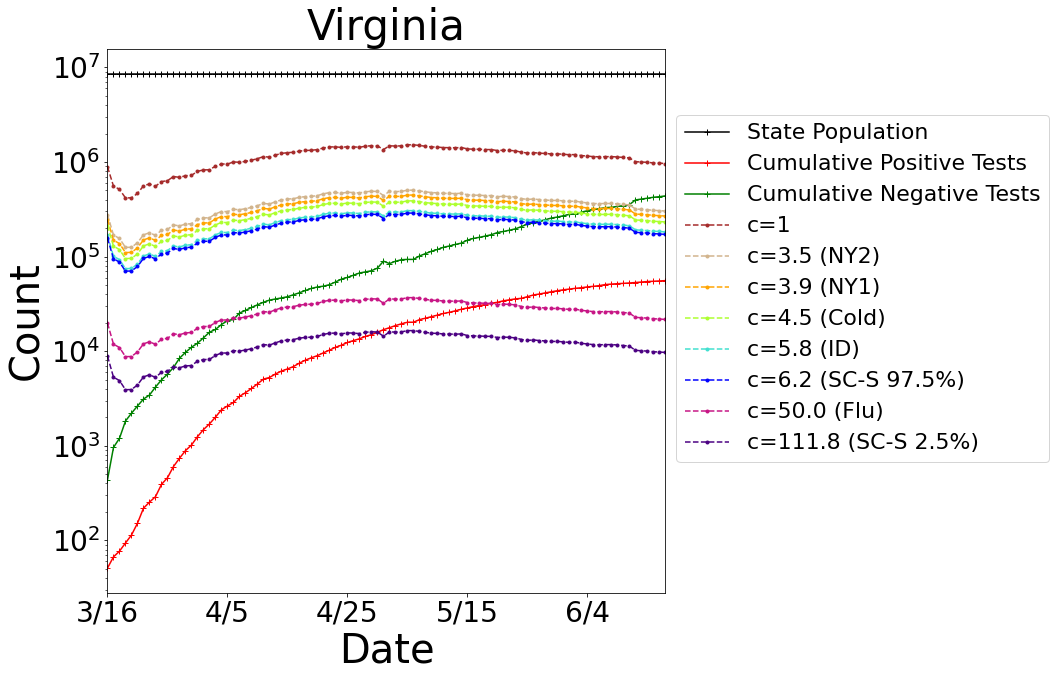

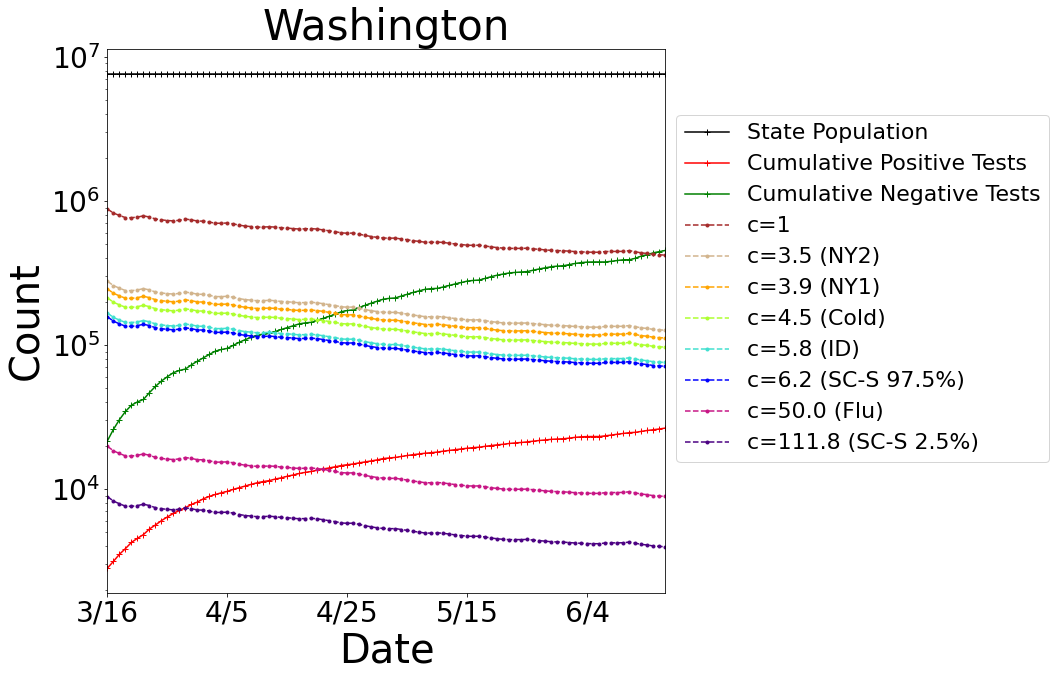

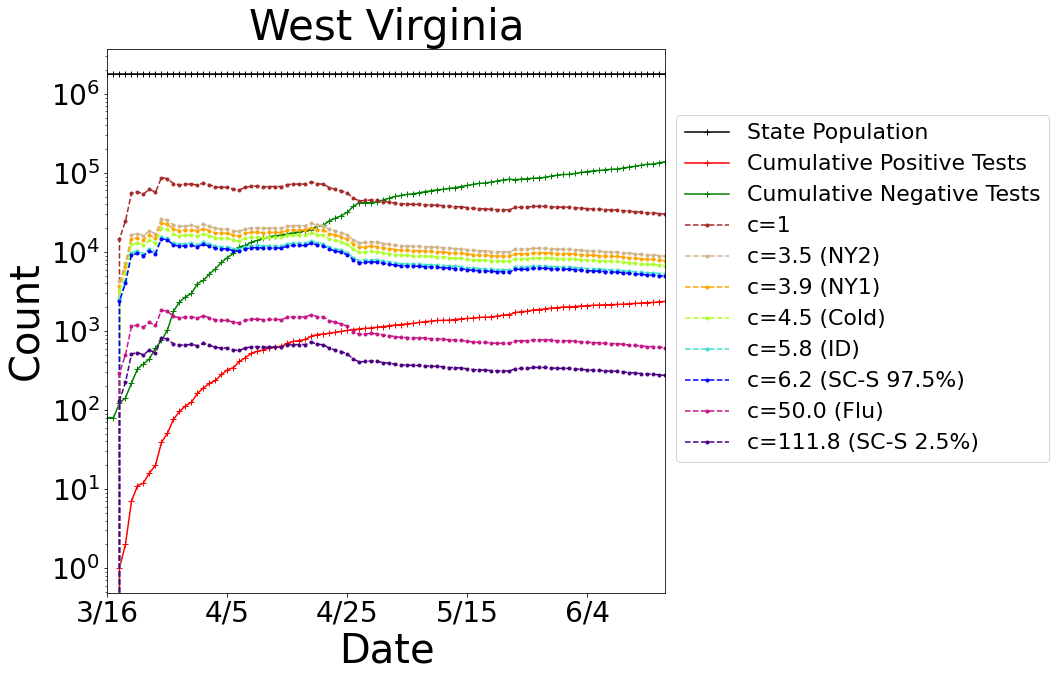

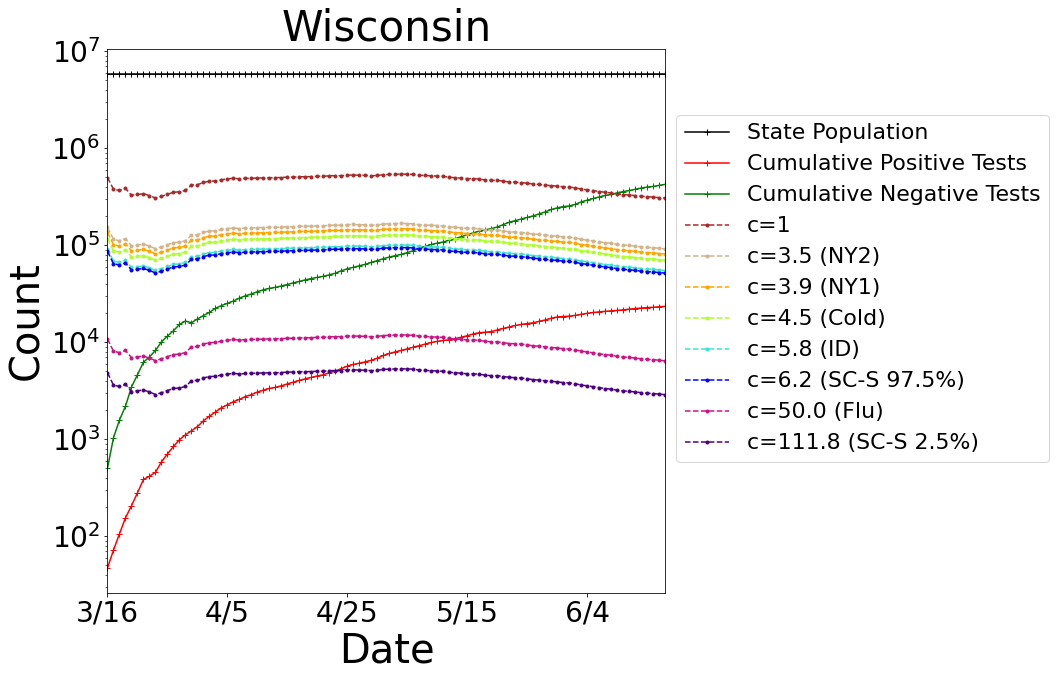

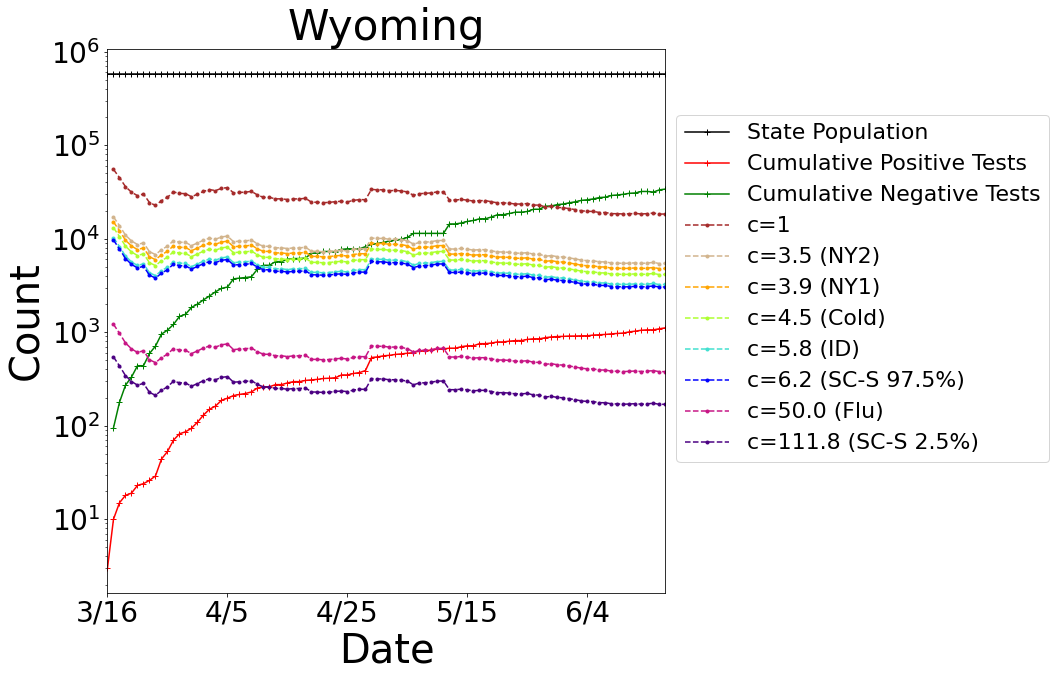

In [9]:
colors = ['brown', 'tan', 'orange', 'greenyellow', 'turquoise', 'blue', 'mediumvioletred', 'indigo']
def plot_for_cs(state, cs, save_dir, extension):
    plot_pos_neg_pop(state, dates)
    plt.title(state_full_names[state], fontsize=42)
    for i, (c_name, c_key) in enumerate(cs.items()):
        try:
            latent_totals = np.array([
                get_latent_total(state, date, c_key(j)) for j, date in enumerate(dates)])
        except:
            latent_totals = np.array([
                get_latent_total(state, date, c_key) for j, date in enumerate(dates)])
        plt.semilogy(latent_totals, color=colors[i], label='{}'.format(c_name), linestyle='--', marker=markers[0])
    finalize_plot(dates, "Count", "{}/{}.{}".format(save_dir, state, extension), separate_legend=True, extension=extension)

for state in state_pops.keys():
    fig = plt.figure(figsize=(10, 10))
    plot_for_cs(state, {'c=1': 1, 
                        'c={:.1f} (NY2)'.format(c_ny2): c_ny2,
                        'c={:.1f} (NY1)'.format(c_ny1): c_ny1,
                        'c={:.1f} (Cold)'.format(c_cold): c_cold, 
                        'c={:.1f} (ID)'.format(c_idaho): c_idaho,
                        'c={:.1f} (SC-S 97.5%)'.format(c_scs_max): c_scs_max,
                        'c={:.1f} (Flu)'.format(c_flu): c_flu,
                        'c={:.1f} (SC-S 2.5%)'.format(c_scs_min): c_scs_min,
                },
               "results/",
               "pdf")